<span id="content"></span>

__目录__



[__1. 原始数据观测__](#1) 

[__2. 原始数据观测__](#2) 

[__3. 数据清洗__](#3)

[__4. 特征选择__](#4)

[__5. 特征处理__](#5)

[__6. 训练模型__](#6)


<span id="1"></span>


# 导入包，数据微处理


In [2]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go 
import plotly.tools as tls
from xgboost import XGBRegressor
from tpot import TPOTRegressor

/usr/local/lib/python3.6/dist-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning:

Falling back to the python version of hypervolume module. Expect this to be very slow.

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning:

Not importing directory /usr/local/lib/python3.6/dist-packages/mpl_toolkits: missing __init__

/usr/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning:

Not importing directory /usr/local/lib/python3.6/dist-packages/google: missing __init__



In [3]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RepeatedKFold, ShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import Imputer
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



In [4]:
py.init_notebook_mode(connected=True)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

+ __读取数据，改名__

In [5]:
train = pd.read_csv('data/jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('data/jinnan_round1_testA_20181227.csv', encoding = 'gb18030')
train.rename(columns={'样本id':'id', '收率':'target'}, inplace = True)
test.rename(columns={'样本id':'id', '收率':'target'}, inplace = True)
target_name = 'target'

+ __存在异常数据，改为 nan__

In [6]:
# 存在异常数据，改为 nan
print(train.loc[1304, 'A25'])
train.loc[1304, 'A25'] = np.nan
train['A25'] = train['A25'].astype(float)
print(train.loc[1304, 'A25'])

1900/3/10 0:00
nan


+ __将 id 前缀去掉__

In [7]:
train['id'] = train['id'].apply(lambda x: int(x.split('_')[1]))
test['id'] = test['id'].apply(lambda x: int(x.split('_')[1]))

<span id="2"></span>

# 原始数据观测
[回到目录](#content)

In [8]:
# 显示数据缺失率，最大类别占比
def show_data(pd_data, sort_target = 'Percentage of missing values'):
    stats = []
    for col in pd_data.columns:
        stats.append((col,
                      pd_data[col].nunique(),
                      pd_data[col].isnull().sum(),
                      pd_data[col].isnull().sum() * 100 / pd_data.shape[0],
                      pd_data[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                      pd_data[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature',
                                            'Unique_values',
                                            'missing number',
                                            'Percentage of missing values',
                                            'Percentage of values in the biggest category',
                                            'type'])
    
    return stats_df.sort_values(sort_target, ascending=False)

In [9]:
# show_data(train)[:10]

In [10]:
show_data(test)[:10]

,Feature,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,147,98.000000,98.000000,float64
7,A7,15,132,88.000000,88.000000,object
8,A8,2,132,88.000000,88.000000,float64
39,B11,11,89,59.333333,59.333333,object
38,B10,50,22,14.666667,14.666667,object
3,A3,2,3,2.000000,97.333333,float64
25,A25,7,1,0.666667,42.000000,float64
27,A27,11,1,0.666667,47.333333,float64
20,A20,52,1,0.666667,20.000000,object
29,B1,13,1,0.666667,56.000000,float64


+ __删除异常值__

In [11]:
train.drop(train[train[target_name] < 0.87].index, inplace=True)
# train.drop(train[train['B14'] == 40].index, inplace=True)
n_train = train.shape[0]

<span id="3"></span>


# 数据清洗

[回到目录](#content)

## 查看缺失数据

In [12]:
full=pd.concat([train, test], ignore_index=True)
print(full.shape)
show_data(full)[:10]

(1533, 44)


,Feature,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
11,A2,1,1491,97.260274,97.260274,float64
26,A8,8,1366,89.106327,89.106327,float64
25,A7,79,1366,89.106327,89.106327,object
30,B11,39,925,60.339204,60.339204,object
29,B10,190,261,17.025440,17.025440,object
43,target,65,150,9.784736,19.895629,float64
21,A3,3,42,2.739726,96.086106,float64
28,B1,21,11,0.717547,54.403131,float64
13,A21,12,3,0.195695,89.889106,float64
15,A23,3,3,0.195695,99.673842,float64


+ __删除缺失率高的特征__

In [13]:
def del_missing_feature(df_data, threhold = 0.85):
    df_data.dropna(axis=1,
                   thresh=(1-threhold) * df_data.shape[0],
                   inplace=True)
    return df_data

In [14]:
full = del_missing_feature(full, 0.85)

In [15]:
show_data(full)[:25]

,Feature,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
27,B11,39,925,60.339204,60.339204,object
26,B10,190,261,17.025440,17.025440,object
40,target,65,150,9.784736,19.895629,float64
20,A3,3,42,2.739726,96.086106,float64
25,B1,21,11,0.717547,54.403131,float64
14,A23,3,3,0.195695,99.673842,float64
12,A21,12,3,0.195695,89.889106,float64
31,B2,3,2,0.130463,98.369211,float64
32,B3,2,2,0.130463,99.804305,float64
17,A26,88,2,0.130463,19.373777,object


## 特征格式化

### 时间数字化

In [16]:
# 处理时间
def timeTranSecond(t):
    try:
        h,m,s=t.split(":")
    except:

        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif pd.isnull(t):
            return np.nan
        else:
            return 0
    
    try:
        tm = (int(h)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm

In [17]:
# 处理时间差
def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+",se)
#         print("sh, sm, eh, em = {}, {}, {}, {}".format(sh, em, eh, em))
    except:
        if pd.isnull(se):
            return np.nan
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm

In [18]:
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        full[f] = full[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')
        
        
for f in ['A20','A28','B4','B9','B10','B11']:
    try:
        full[f] = full[f].apply(getDuration)
    except:
        print(f,'应该在前面被删除了！')

A7 应该在前面被删除了！


### 计算时间差

In [19]:
# t_start 为时间的开始， tn 为中间的时间，减去 t_start 得到时间差
t_start = ['A9', 'A24', 'B5']
tn = {'A9':['A11', 'A14', 'A16'], 'A24':['A26'], 'B5':['B7']}

In [20]:
def t_start_t_end(t):
    if pd.isnull(t[0]) or pd.isnull(t[1]):
        print("t_start = {}, t_end = {}, id = {}".format(t[0], t[1], t[2]))
        return np.nan
        
    if t[1] < t[0]:
        t[1] += 24
        
    dt = t[1] - t[0]

    if(dt > 24 or dt < 0):
        print("dt error, t_start = {}, t_end = {}, id = {}".format(t[0], t[1], t[2]))
        return np.nan
    
    return dt
    

In [21]:
for t_s in t_start:
    for t_e in tn[t_s]:
        full[t_e+'-'+t_s] = full[[t_s,t_e, target_name]].apply(t_start_t_end, axis=1)

t_start = 19.0, t_end = nan, id = 0.8909999999999999
t_start = nan, t_end = nan, id = 0.935
t_start = nan, t_end = 16.5, id = 0.9229999999999999


+ __结果保留3位小数__

In [22]:
full = full.apply(lambda x:round(x, 3))
print(full.shape)
full[:10]

(1533, 46)


,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A3,A4,A5,A6,A9,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6,B7,B8,B9,id,target,A11-A9,A14-A9,A16-A9,A26-A24,B7-B5
0,300,100,16.5,102.0,0.2,17.5,103.0,18.5,104.0,0.2,300,0.5,50.0,9.0,5.0,22.0,75.0,22.5,70.0,0.5,405.0,700,13.5,38.0,15.5,350.0,1.5,NaN,800.0,0.15,400,3.5,3.5,1.0,8.0,65,11.5,45.0,1.5,1528,0.879,1.0,2.0,3.0,0.5,3.5
1,300,101,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,1.0,50.0,9.0,5.0,20.0,80.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,6.0,45.0,1.5,1698,0.902,1.0,2.0,3.0,1.0,7.0
2,300,102,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,0.5,50.0,9.0,5.0,20.0,79.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,1.0,45.0,1.5,639,0.936,1.0,2.0,3.0,1.0,2.0
3,300,100,4.0,102.0,0.2,5.0,103.0,6.0,104.0,0.2,200,0.5,50.0,10.0,5.0,7.5,70.0,8.0,78.0,1.0,405.0,700,1.5,38.0,3.0,290.0,1.5,NaN,800.0,0.15,400,3.5,3.5,1.0,15.5,65,18.0,45.0,1.5,483,0.902,1.0,2.0,3.0,0.5,2.5
4,300,101,1.0,103.0,0.2,2.0,104.0,3.0,105.0,0.2,200,1.0,50.0,9.0,5.0,4.0,80.0,5.0,73.0,1.0,405.0,700,22.0,29.0,0.0,320.0,1.5,1.0,1200.0,0.15,420,3.5,3.5,1.0,7.0,80,9.0,45.0,1.5,617,0.983,1.0,2.0,3.0,1.0,2.0
5,300,100,4.5,103.0,0.2,5.5,104.0,6.5,102.0,0.2,300,0.5,50.0,9.0,5.0,12.0,70.0,12.5,75.0,0.5,405.0,700,2.0,39.0,3.5,NaN,1.5,NaN,800.0,0.15,420,3.5,3.5,2.0,20.0,65,3.0,45.0,1.5,373,0.935,1.0,2.0,3.0,0.5,7.0
6,300,101,11.0,103.0,0.2,12.0,104.0,13.0,105.0,0.2,200,1.0,50.0,9.0,5.0,14.0,80.0,15.0,73.0,1.0,405.0,700,8.0,29.0,10.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,17.0,80,19.0,45.0,1.5,577,0.902,1.0,2.0,3.0,1.0,2.0
7,300,101,9.0,102.0,0.2,10.0,103.0,11.0,103.0,0.2,200,1.0,50.0,9.0,5.0,12.0,78.0,13.0,73.0,1.0,405.0,700,6.0,29.0,8.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,15.0,80,17.0,45.0,1.5,212,0.891,1.0,2.0,3.0,1.0,2.0
8,300,100,20.0,101.0,0.2,21.0,102.0,22.0,105.0,0.2,300,0.5,50.0,9.0,5.0,23.5,70.0,0.0,78.0,1.0,405.0,700,17.5,21.0,19.0,340.0,1.5,NaN,800.0,0.15,420,3.5,3.5,1.5,4.5,65,6.5,45.0,1.5,521,0.947,1.0,2.0,3.0,0.5,2.0
9,300,100,13.5,102.0,0.2,14.5,103.0,15.5,105.0,0.2,200,0.5,50.0,9.0,5.0,17.0,70.0,17.5,78.0,1.0,405.0,700,11.0,21.0,12.5,280.0,1.5,NaN,800.0,0.15,400,3.5,3.5,1.0,0.0,64,2.0,50.0,1.5,1026,0.902,1.0,2.0,3.0,0.5,2.0


## 填补缺失值

In [23]:
full.head()

,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A3,A4,A5,A6,A9,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6,B7,B8,B9,id,target,A11-A9,A14-A9,A16-A9,A26-A24,B7-B5
0,300,100,16.5,102.0,0.2,17.5,103.0,18.5,104.0,0.2,300,0.5,50.0,9.0,5.0,22.0,75.0,22.5,70.0,0.5,405.0,700,13.5,38.0,15.5,350.0,1.5,NaN,800.0,0.15,400,3.5,3.5,1.0,8.0,65,11.5,45.0,1.5,1528,0.879,1.0,2.0,3.0,0.5,3.5
1,300,101,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,1.0,50.0,9.0,5.0,20.0,80.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,6.0,45.0,1.5,1698,0.902,1.0,2.0,3.0,1.0,7.0
2,300,102,17.0,103.0,0.2,18.0,104.0,19.0,105.0,0.2,200,0.5,50.0,9.0,5.0,20.0,79.0,21.0,73.0,1.0,405.0,700,14.0,29.0,16.0,320.0,1.5,1.0,1200.0,0.15,400,3.5,3.5,1.0,23.0,80,1.0,45.0,1.5,639,0.936,1.0,2.0,3.0,1.0,2.0
3,300,100,4.0,102.0,0.2,5.0,103.0,6.0,104.0,0.2,200,0.5,50.0,10.0,5.0,7.5,70.0,8.0,78.0,1.0,405.0,700,1.5,38.0,3.0,290.0,1.5,NaN,800.0,0.15,400,3.5,3.5,1.0,15.5,65,18.0,45.0,1.5,483,0.902,1.0,2.0,3.0,0.5,2.5
4,300,101,1.0,103.0,0.2,2.0,104.0,3.0,105.0,0.2,200,1.0,50.0,9.0,5.0,4.0,80.0,5.0,73.0,1.0,405.0,700,22.0,29.0,0.0,320.0,1.5,1.0,1200.0,0.15,420,3.5,3.5,1.0,7.0,80,9.0,45.0,1.5,617,0.983,1.0,2.0,3.0,1.0,2.0


In [24]:
print(full.shape)
show_data(full)[:25]

(1533, 46)


,Feature,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
27,B11,8,925,60.339204,60.339204,float64
26,B10,17,261,17.025440,69.602087,float64
40,target,62,150,9.784736,19.895629,float64
20,A3,3,42,2.739726,96.086106,float64
25,B1,21,11,0.717547,54.403131,float64
14,A23,3,3,0.195695,99.673842,float64
12,A21,12,3,0.195695,89.889106,float64
44,A26-A24,16,2,0.130463,55.577299,float64
31,B2,3,2,0.130463,98.369211,float64
32,B3,2,2,0.130463,99.804305,float64


In [25]:
full.groupby(['A3'])[[target_name]].agg(['mean','median','count'])#['target'].sort_values('mean', ascending=False)

target             
           mean median count
A3                          
270.0  0.921273  0.935    11
340.0  0.926000  0.920     6
405.0  0.925129  0.925  1327

+ __nan 数量少于 5 的填充众数，大于等于 5 的填充-1__

In [26]:
def fill_nan(x, threshold = 5):
    if x.name == target_name:
        return x
    
    if x.isnull().sum() < 5:
        x.fillna(x.mode()[0], inplace=True)
    else:
        x.fillna(-1, inplace=True)
    return x

full = full.apply(fill_nan, axis=0)
show_data(full, 'Unique_values')

,Feature,Unique_values,missing number,Percentage of missing values,Percentage of values in the biggest category,type
39,id,1533,0,0.000000,0.065232,int64
24,A9,96,0,0.000000,18.590998,float64
7,A16,95,0,0.000000,18.460535,float64
2,A11,94,0,0.000000,18.525766,float64
5,A14,94,0,0.000000,18.525766,float64
15,A24,92,0,0.000000,18.917156,float64
17,A26,87,0,0.000000,19.504240,float64
22,A5,64,0,0.000000,19.569472,float64
40,target,62,150,9.784736,19.895629,float64
34,B5,62,0,0.000000,18.003914,float64


In [27]:
# 测试 get_dummies

# print(full.shape)
# full2 = full.copy()
# obj_col = [col for col in full2.columns if col != 'id']
# full2[obj_col] = full2[obj_col].astype(object)
# full2 = pd.get_dummies(full2)
# print(full2.shape)
# full2.head()

<span id="3"></span>


# 特征工程
（特征数字化，选择相关性强的特征）

[回到目录](#content)

## 相关系数矩阵

46


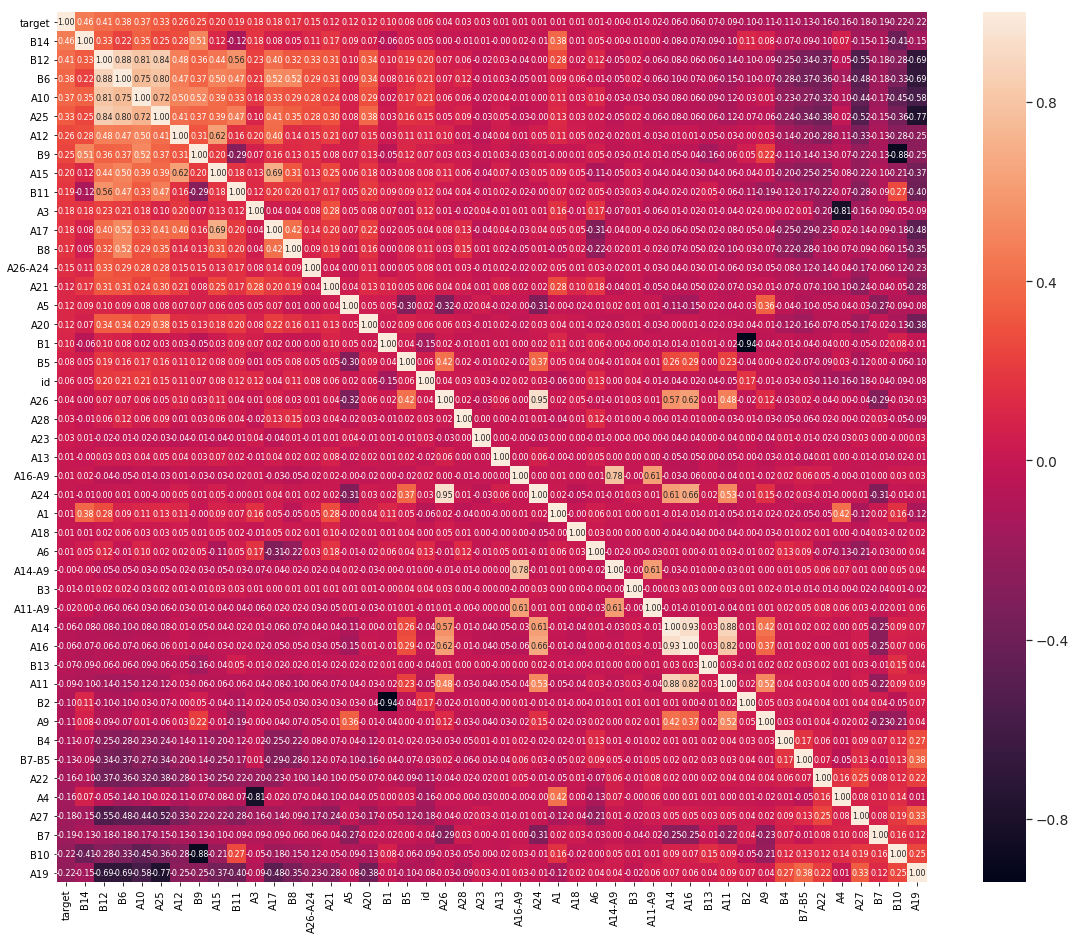

In [28]:
def heatmap(pd_data):
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(corrmat, vmax=.8, square=True)

def heatmap_font(pd_data, k=-1, target=target_name):
    # k is the number of variables for heatmap
    if k == -1:
        k = pd_data.shape[1]
        
    corrmat = pd_data.corr()
    f, ax = plt.subplots(figsize=(20, 16))
    cols = corrmat.nlargest(k, target)[target].index
    cm = np.corrcoef(pd_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm,
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 8}, 
                     yticklabels=cols.values,
                     xticklabels=cols.values)
    plt.show()
    

    
train_data = full[:train.shape[0]]
test_data = full[train.shape[0]:]
# heatmap(data_map)
print(train_data.shape[1])
heatmap_font(train_data)


## 特征之间的关系可视化

### 通用画图函数

+ __画数据分布图__

In [30]:
def plt_cnt(df_data, idx):
    cnt = df_data[idx].value_counts(dropna=False).sort_index(ascending=True)
    plt.figure(figsize=(18,5))
    cnt.plot.bar()
    plt.title(idx)
    plt.show()
    return cnt

+ __画 A 与 B 的统计图__

In [31]:
def plt_A_B(df_data, idx_A, idx_B, bias):
    plt.figure(figsize=(18,5))
    (df_data.groupby(idx_A)[idx_B].mean() - bias).plot.bar()
    plt.title(idx_B)
    plt.show()

+ __画 A 与 B 的箱体图__

In [32]:
def plt_box_A_B(df_data, idx_A, idx_B):
    plt.figure(figsize=(18,5))
    sns.boxplot(x=idx_A, y=idx_B, data=df_data)
    sns.stripplot(x=idx_A, y=idx_B, data=df_data)
    plt.title(idx_B)
    plt.show()

+ __画 A 与 B 的散点图__

In [33]:
def plt_point_A_B(df_data, idx_A, idx_B):
#     plt.figure(figsize=(18,5))
    df_data.plot(kind='scatter', x=idx_A, y=idx_B, figsize=(18,5))
#     plt.show()

### id 与 target，B14

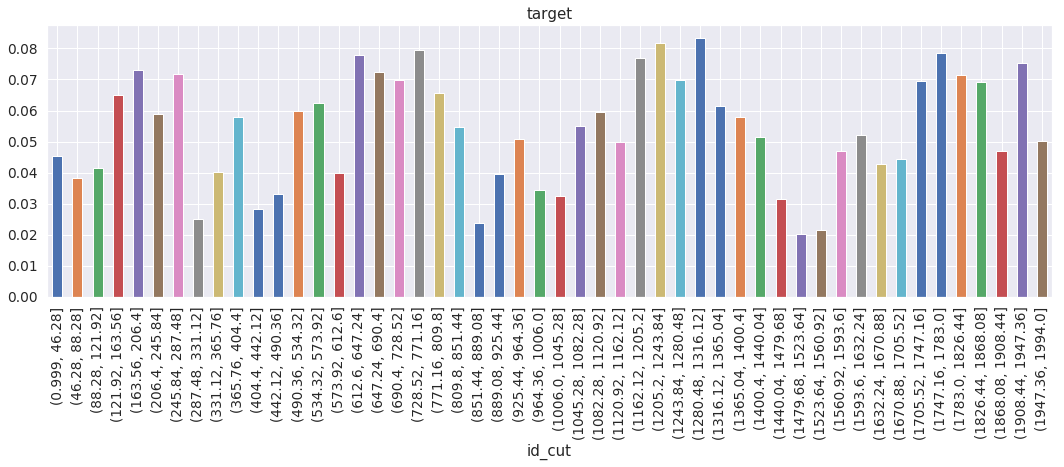

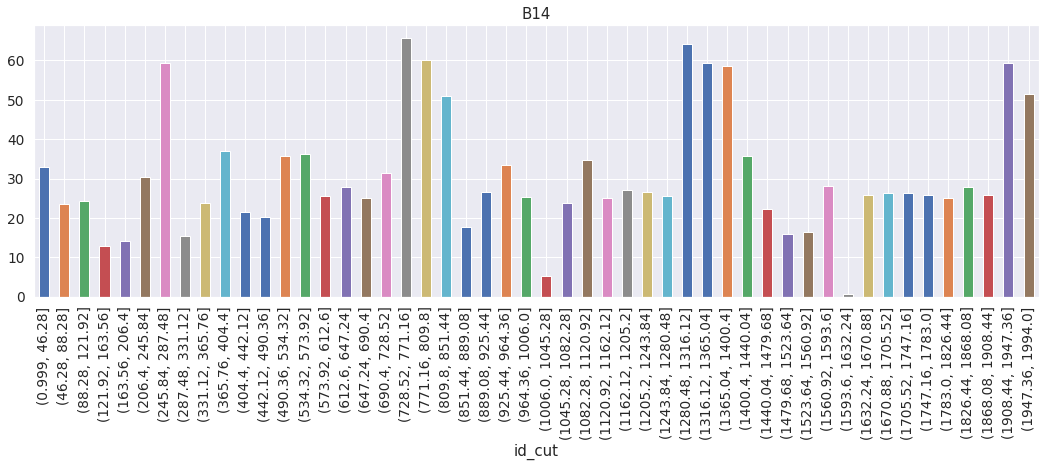

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


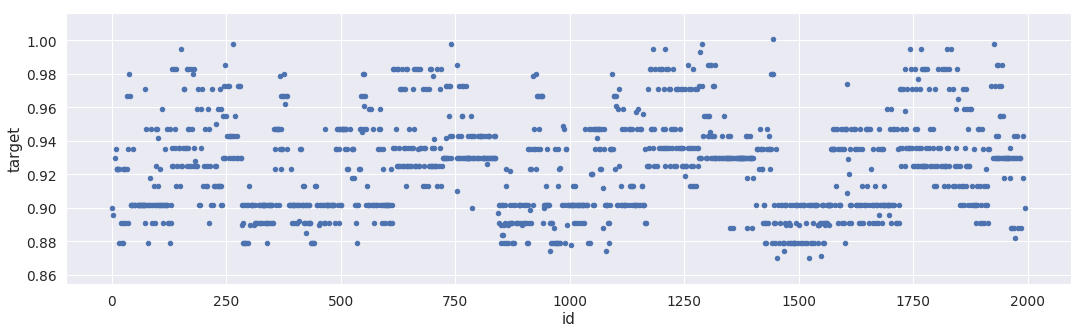

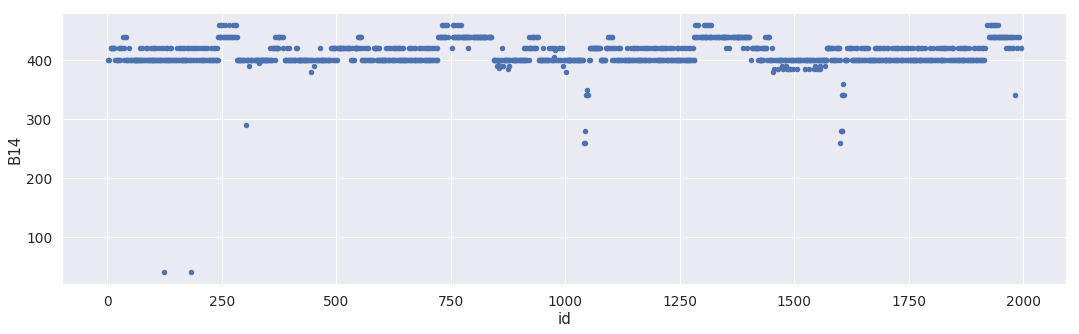

In [49]:
# train_data['id_500'] = full['id'] % 500
# train_data['id_500_cut'] = pd.qcut(train_data['id_500'], 10)
# plt.figure(figsize=(18,5))
# (train_data[train_data['target'] != -1].groupby('id_500_cut')['target'].mean() - 0.87).plot.bar()
# plt.show()

# sns.boxplot(x='id_500_cut', y='target', data=train_data)
# sns.stripplot(x='id_500_cut', y='target', data=train_data)

train_data['id_cut'] = pd.qcut(train_data['id'], 50)
plt_A_B(train_data, 'id_cut', target_name, 0.87)
plt_A_B(train_data, 'id_cut', 'B14', 380)
plt_point_A_B(train_data, 'id', target_name)
plt_point_A_B(train_data, 'id', 'B14')
train_data.drop(['id_cut'], axis=1, inplace=True)

### B1 与 B2 (反比，但对 target 无影响)
故删除 B1 和 B2

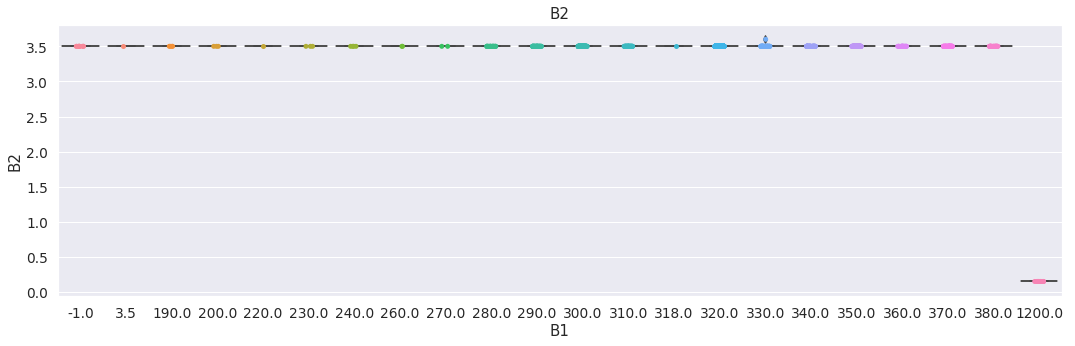

In [38]:
plt_A_B(train_data, 'B1', 'B2', 0)

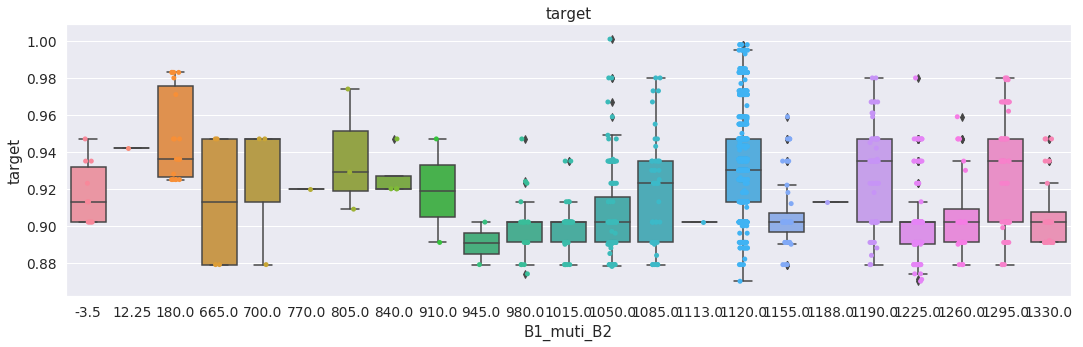

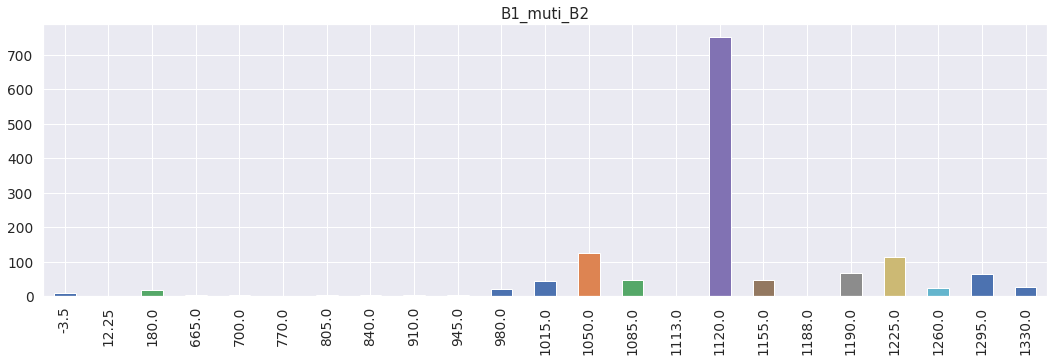

In [41]:
train_data['B1_muti_B2'] = train_data['B1'] * train_data['B2']
plt_A_B(train_data, 'B1_muti_B2', 'target', 0.87)
plt_cnt(train_data, 'B1_muti_B2');

In [33]:
# heatmap_font(train_data[['target', 'B1_muti_B2']])

### B12 与 target

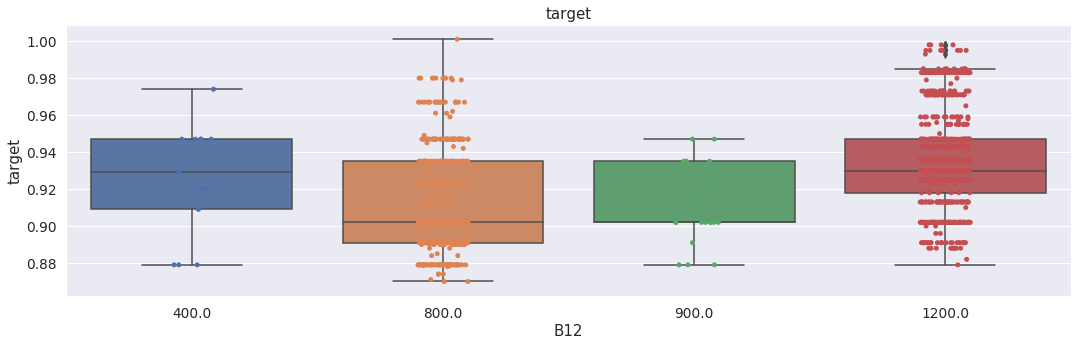

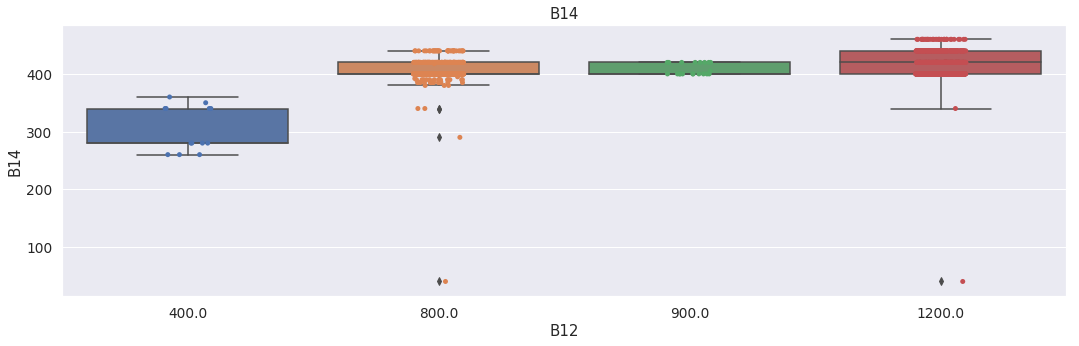

In [44]:
plt_box_A_B(train_data, 'B12', 'target')
plt_box_A_B(train_data, 'B12', 'B14')


### B14 与 target, A1, B9, B10
将 B14 分段

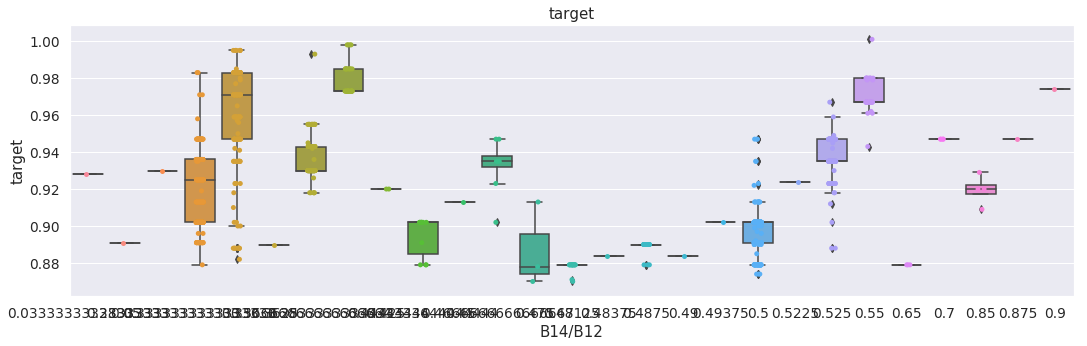

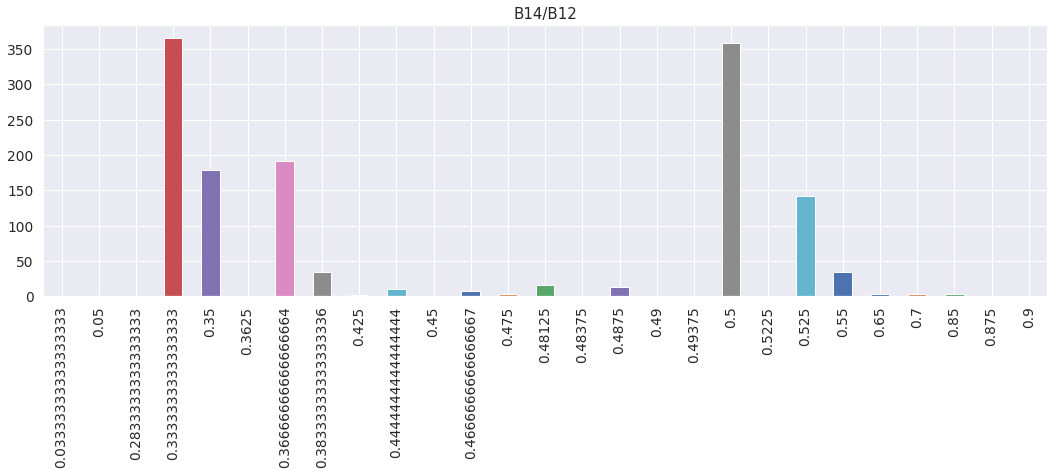

0.033333      1
0.050000      1
0.283333      1
0.333333    366
0.350000    179
0.362500      1
0.366667    192
0.383333     35
0.425000      2
0.444444     11
0.450000      1
0.466667      8
0.475000      3
0.481250     16
0.483750      1
0.487500     14
0.490000      1
0.493750      1
0.500000    359
0.522500      1
0.525000    142
0.550000     34
0.650000      3
0.700000      4
0.850000      4
0.875000      1
0.900000      1
Name: B14/B12, dtype: int64


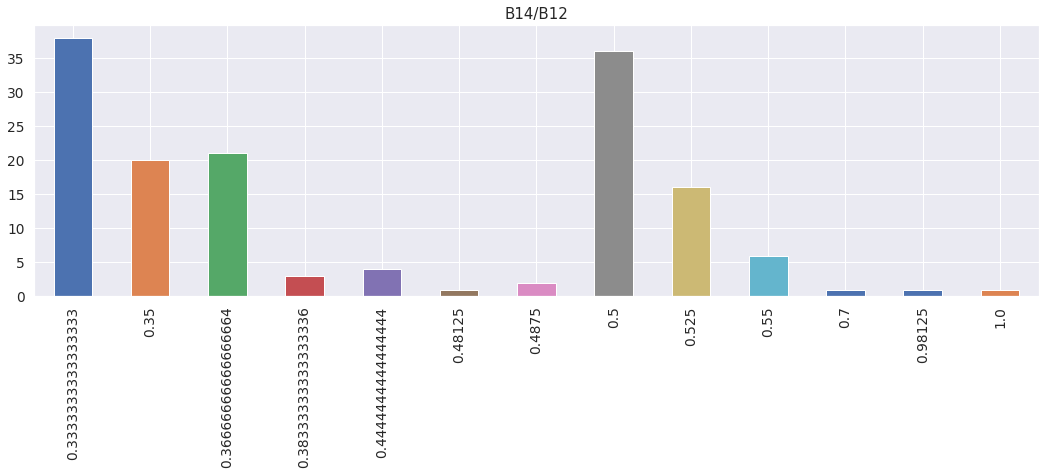

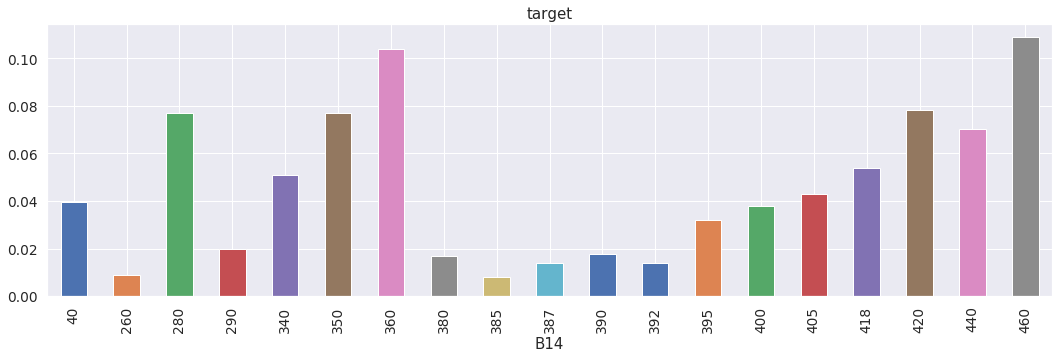

In [50]:
train_data['B14/B12'] = train_data['B14'] / train_data['B12']
test_data['B14/B12'] = test_data['B14'] / test_data['B12']
plt_box_A_B(train_data, 'B14/B12', 'target')
print(plt_cnt(train_data, 'B14/B12'))
plt_cnt(test_data, 'B14/B12')
plt_A_B(train_data, 'B14', 'target', 0.87)
# plt_A_B(train_data, 'B14', 'A1', 0)
# plt_A_B(train_data, 'B14', 'B9', 0)
# plt_A_B(train_data, 'B14', 'B10', 0)
# plt_cnt(train_data, 'B14')
# plt_cnt(test_data, 'B14')

### B10 与 B9, B14(B10 的缺失对B14造成影响)
将 B10 按照是否缺失值分类
B10 与 B9 强相关，删除 B9

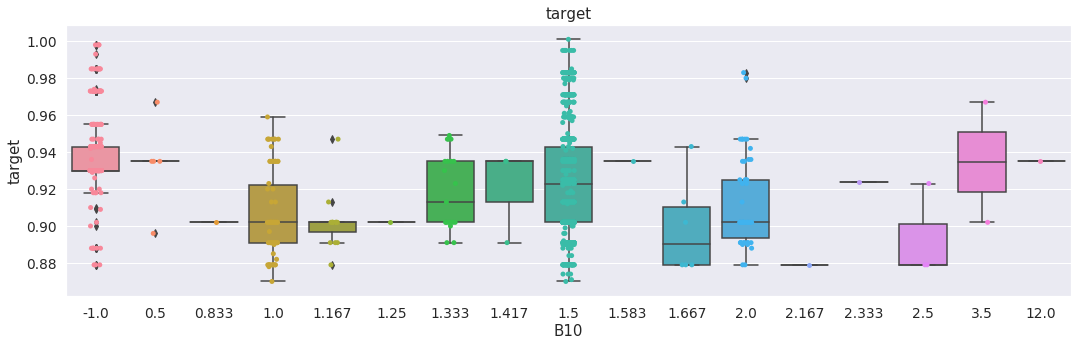

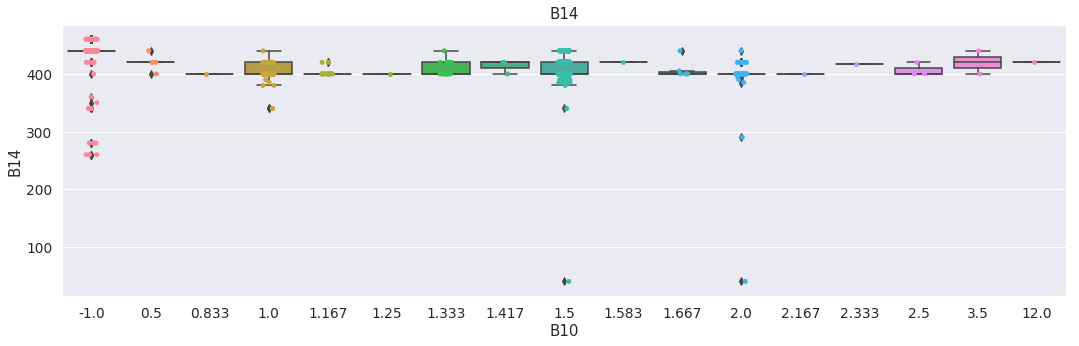

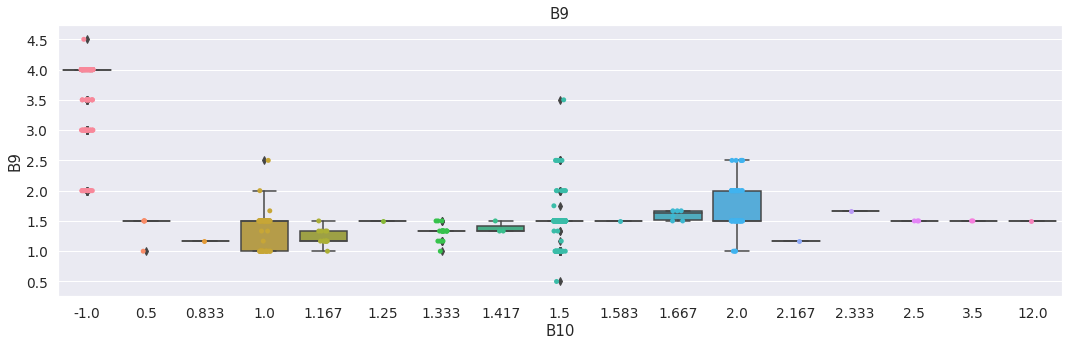

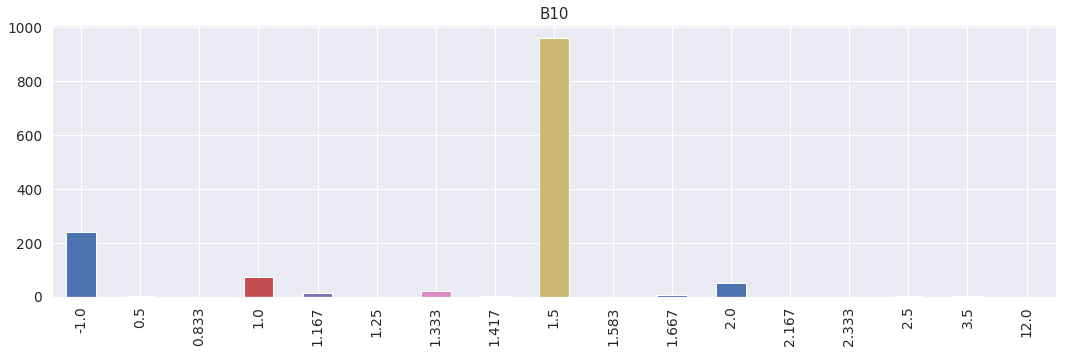

-1.000     239
 0.500       5
 0.833       1
 1.000      74
 1.167      15
 1.250       1
 1.333      21
 1.417       3
 1.500     959
 1.583       1
 1.667       6
 2.000      50
 2.167       1
 2.333       1
 2.500       3
 3.500       2
 12.000      1
Name: B10, dtype: int64

In [43]:
plt_A_B(train_data, 'B10', 'target', 0.87)
plt_A_B(train_data, 'B10', 'B14', 400)
plt_A_B(train_data, 'B10', 'B9', 0)
plt_cnt(train_data, 'B10')
# plt_cnt(train_data.loc[train_data['B10']==-1, ['B14']], 'B14')

### A10 与 B6, B12, A25, B14, B10
删除相关性大的 B6，B12，A25

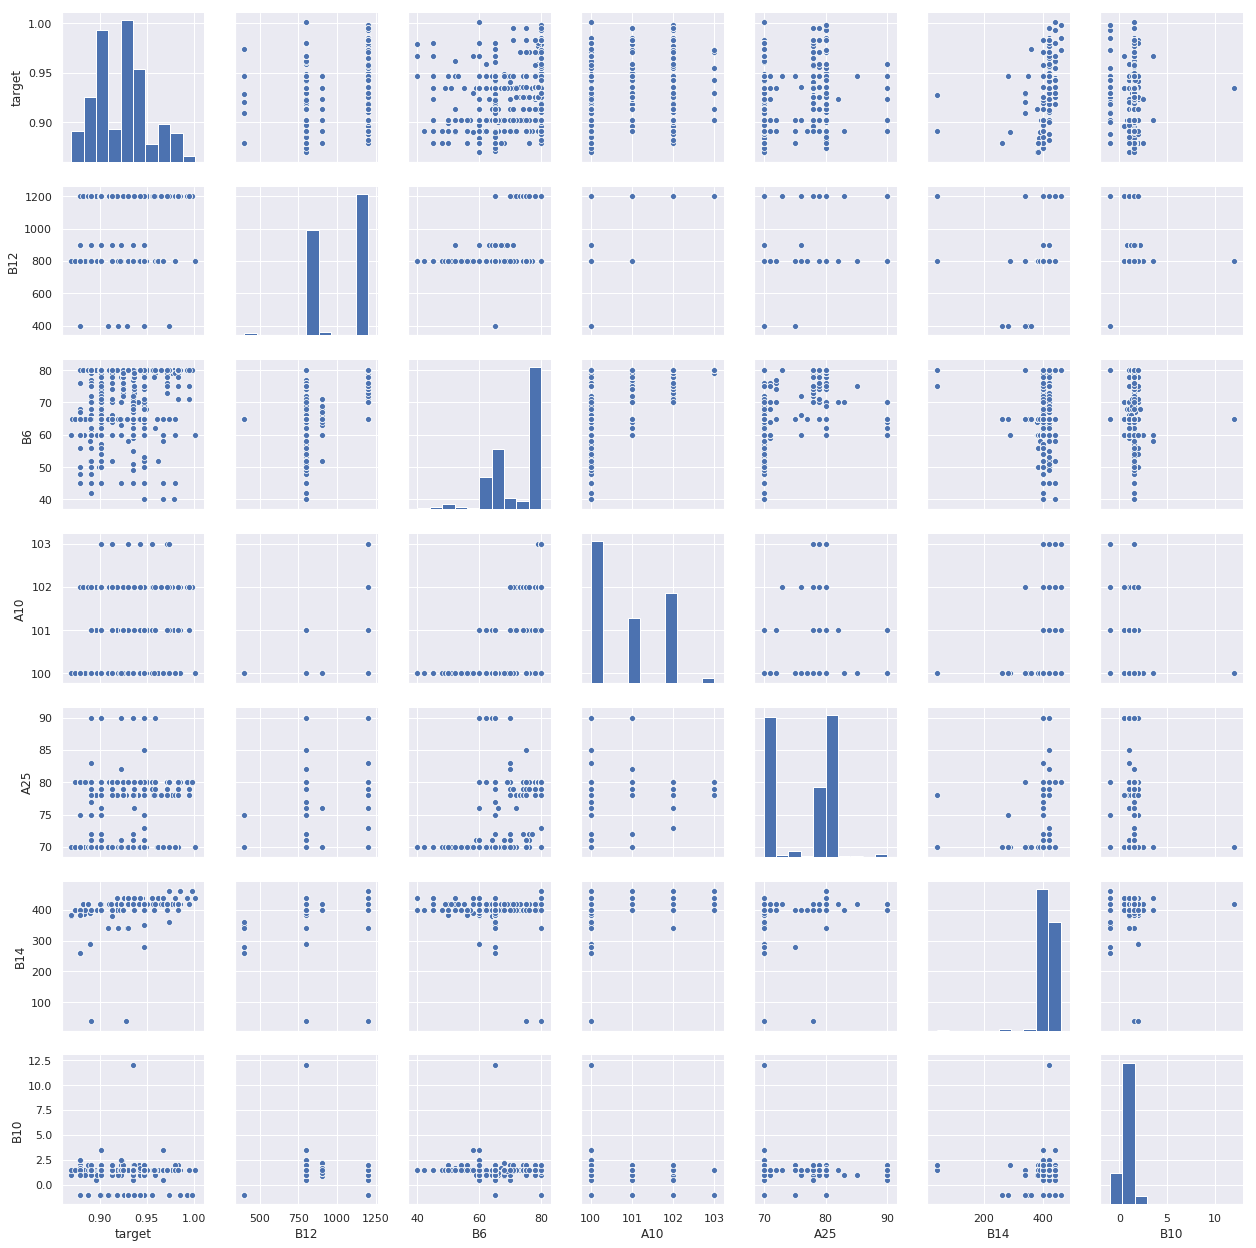

In [36]:
sns.set()
cols = ['target', 'B12', 'B6','A10', 'A25', 'B14', 'B10']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

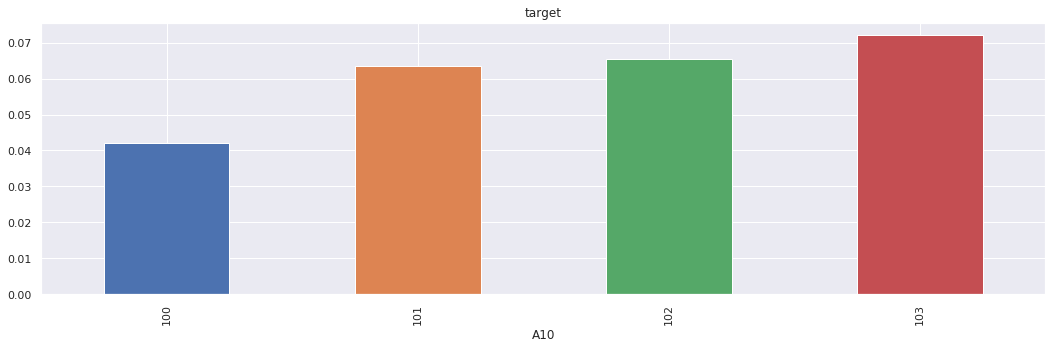

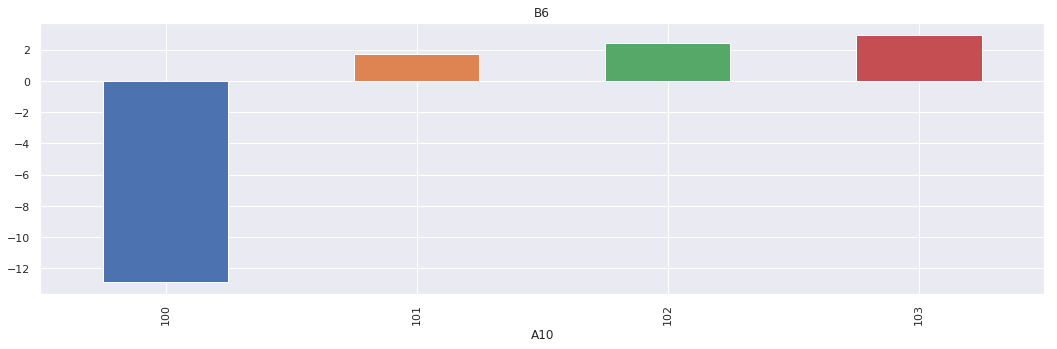

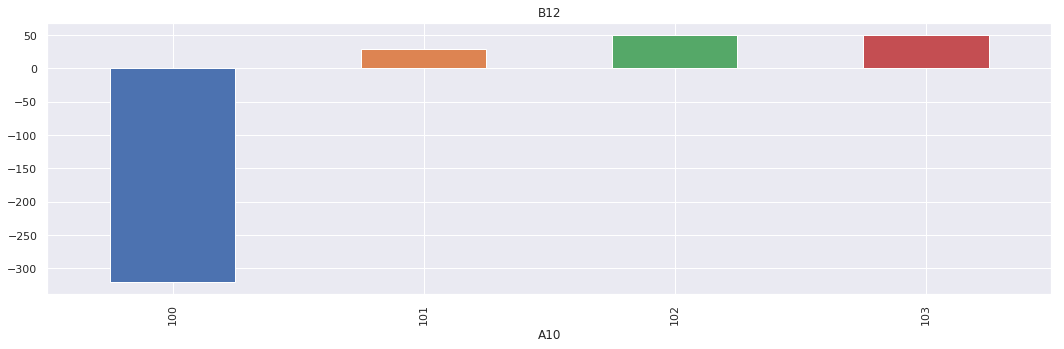

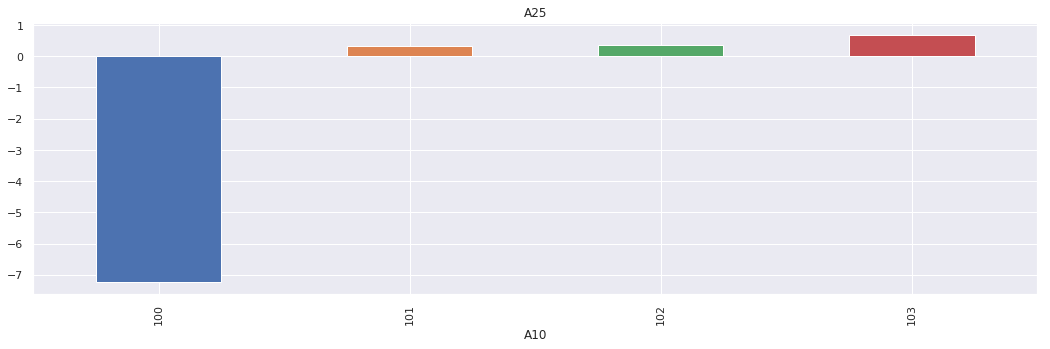

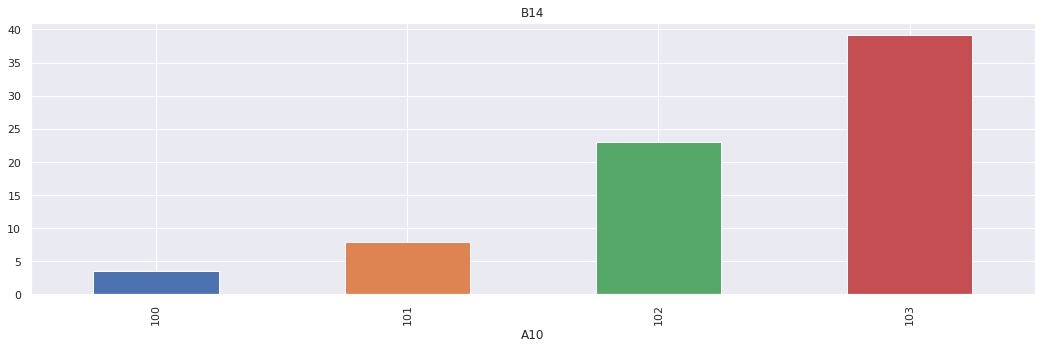

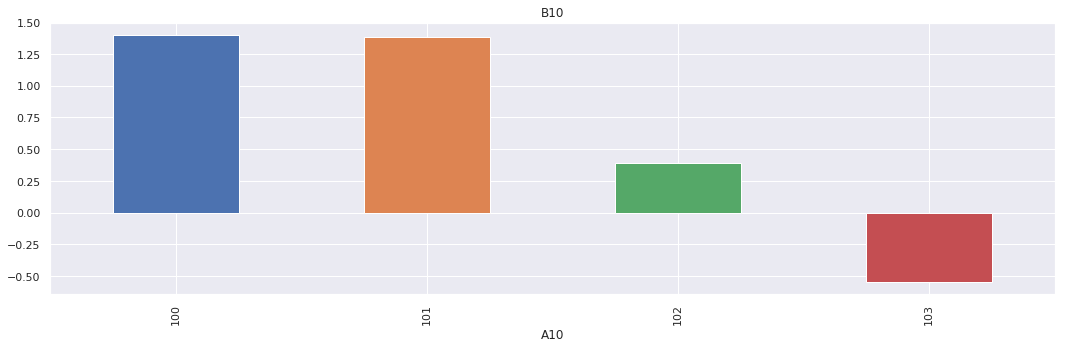

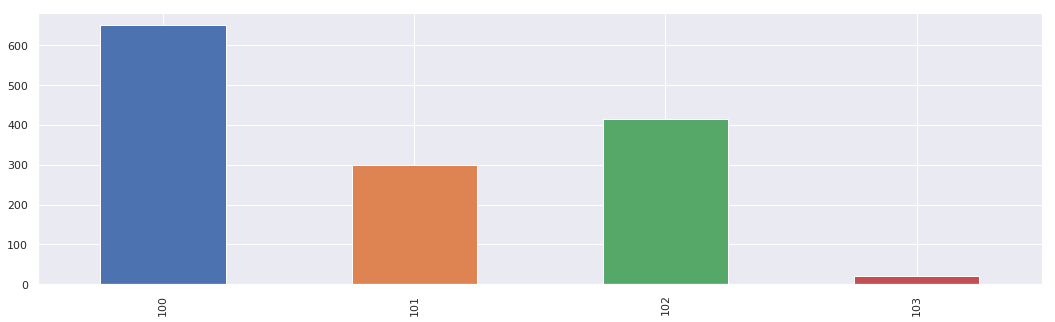

100    649
101    298
102    414
103     22
Name: A10, dtype: int64

In [37]:
plt_A_B(train_data, 'A10', 'target', 0.87)
plt_A_B(train_data, 'A10', 'B6', 77)
plt_A_B(train_data, 'A10', 'B12', 1150)
plt_A_B(train_data, 'A10', 'A25', 79)
plt_A_B(train_data, 'A10', 'B14', 400)
plt_A_B(train_data, 'A10', 'B10', 0)
plt_cnt(train_data, 'A10')

### A19 与 A10, B6, B12, A25
将 A19 分成段

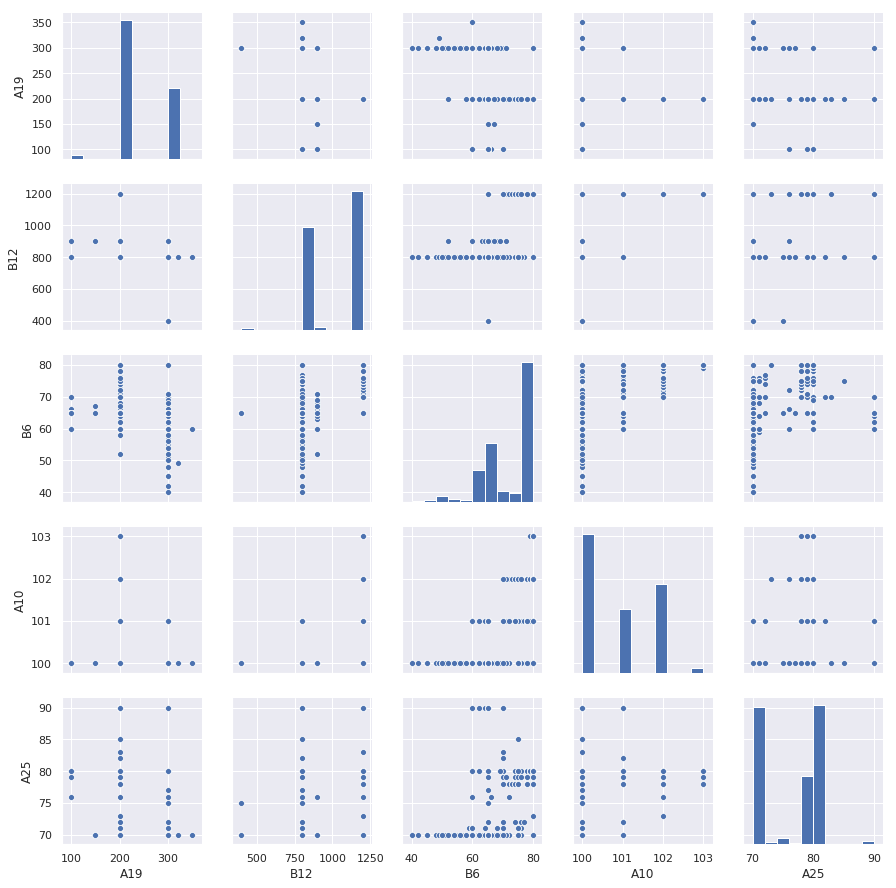

In [38]:
sns.set()
cols = ['A19', 'B12', 'B6','A10', 'A25']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();

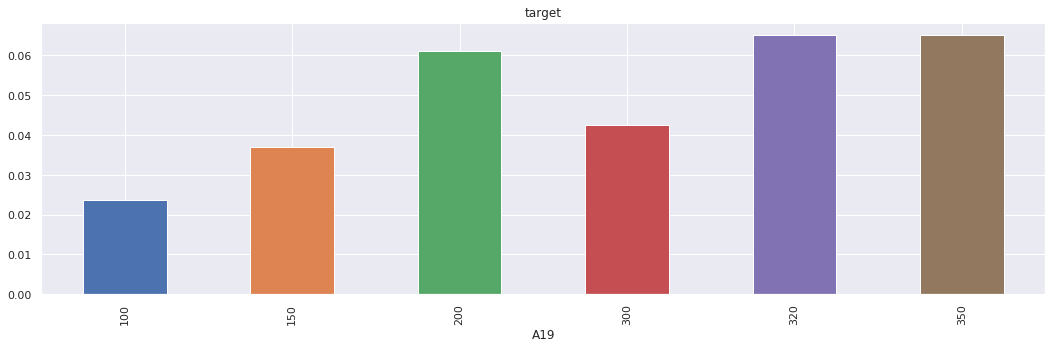

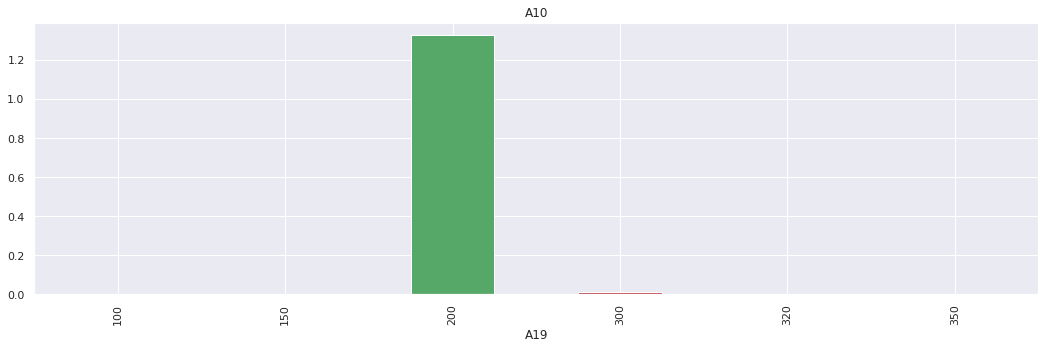

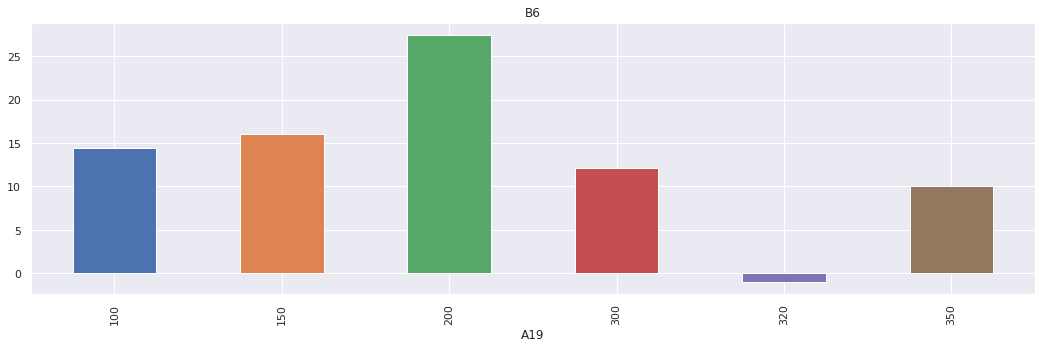

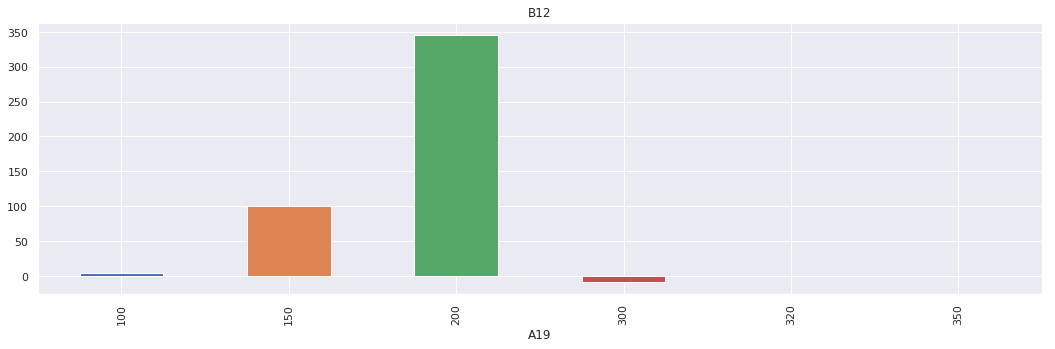

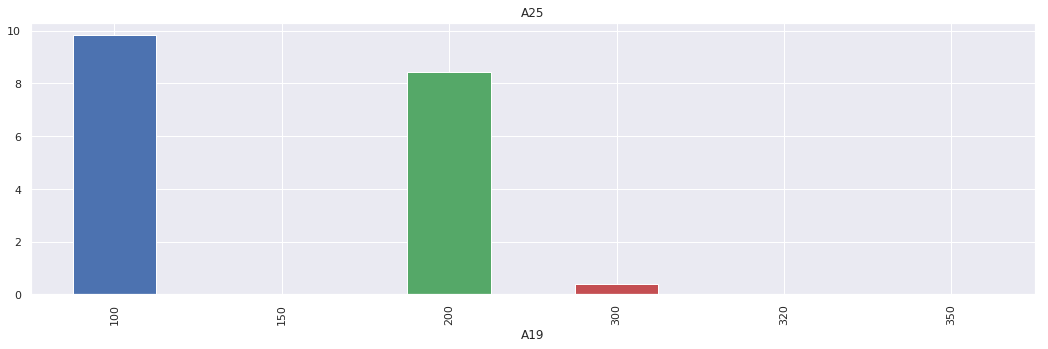

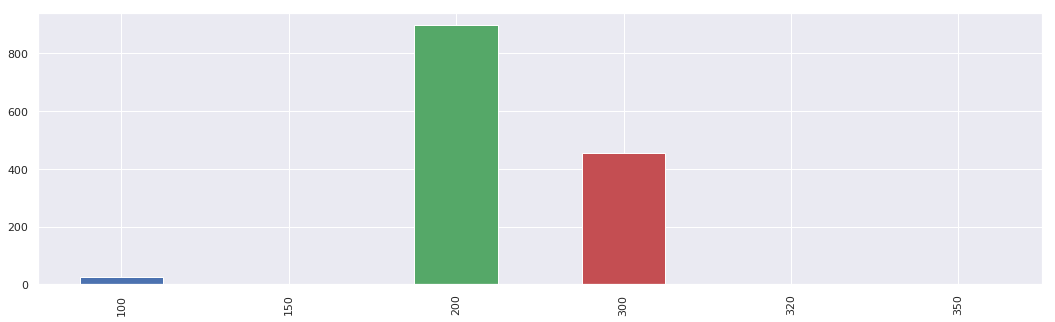

100     27
150      2
200    897
300    455
320      1
350      1
Name: A19, dtype: int64

In [39]:
plt_A_B(train_data, 'A19', 'target', 0.87)
plt_A_B(train_data, 'A19', 'A10', 100)
plt_A_B(train_data, 'A19', 'B6', 50)
plt_A_B(train_data, 'A19', 'B12', 800)
plt_A_B(train_data, 'A19', 'A25', 70)
plt_cnt(train_data, 'A19')

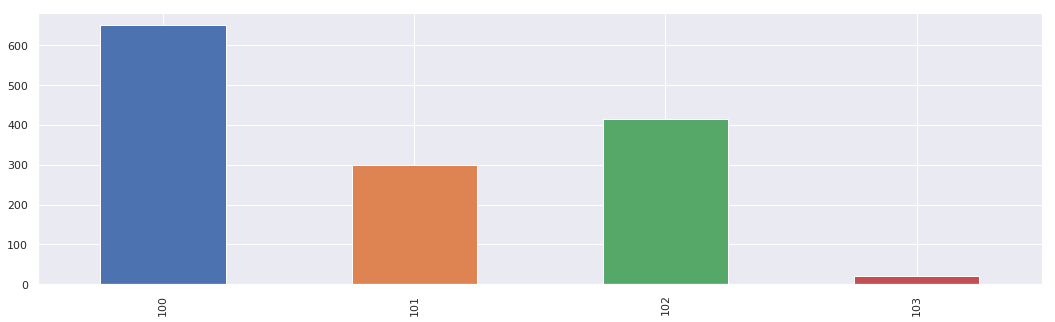

100    649
101    298
102    414
103     22
Name: A10, dtype: int64

In [40]:
plt_cnt(train_data, 'A10')

### A3 与 A4
A4/A3 保持不变，而 A3 缺失与否对结果影响较大，所以删除 A3 和 A4，对 A3 是否缺失进行分类

In [41]:
# train_data['A4/A3'] = train_data['A4'] / train_data['A3']
# plt_A_B(train_data, 'A4/A3', 'target', 0.87)
# plt_cnt(train_data, 'A4/A3')

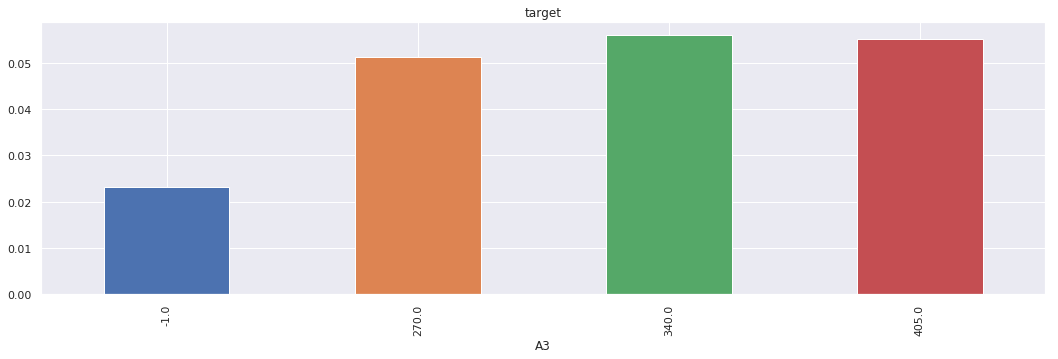

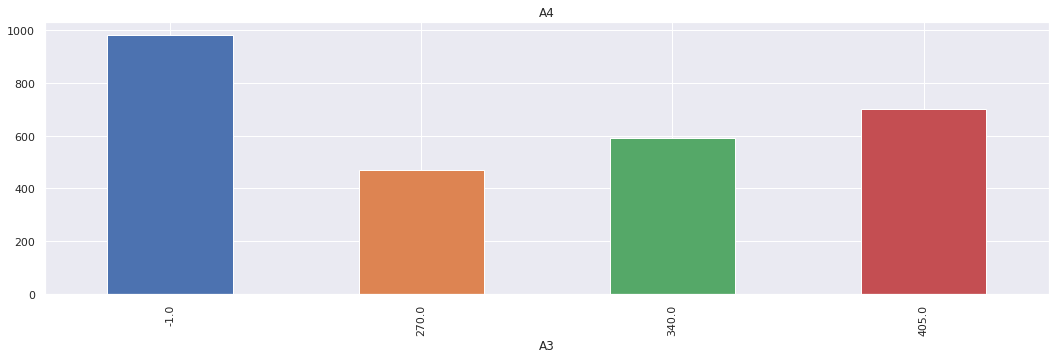

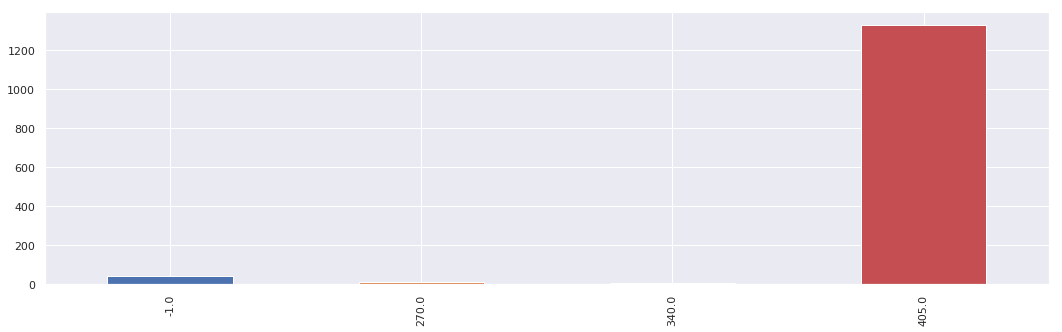

-1.0        39
 270.0      11
 340.0       6
 405.0    1327
Name: A3, dtype: int64

In [42]:
plt_A_B(train_data, 'A3', 'target', 0.87)
plt_A_B(train_data, 'A3', 'A4', 0)
plt_cnt(train_data, 'A3')

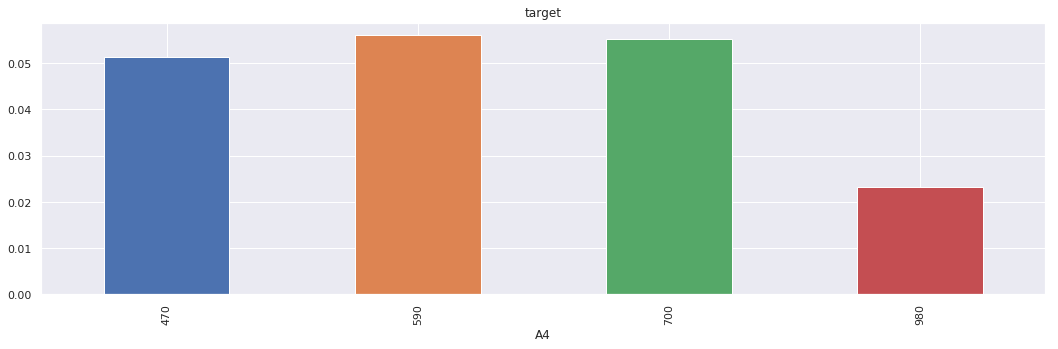

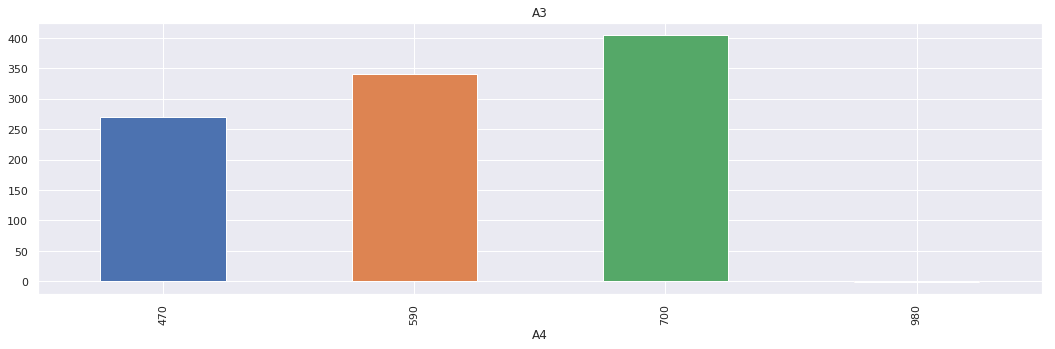

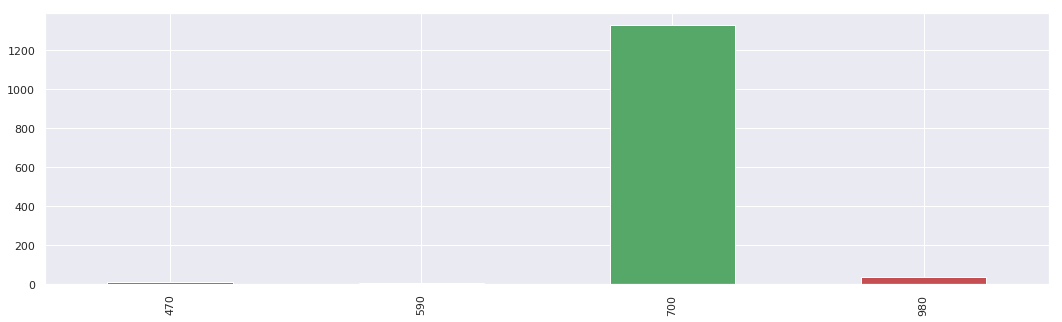

470      11
590       6
700    1327
980      39
Name: A4, dtype: int64

In [43]:
plt_A_B(train_data, 'A4', 'target', 0.87)
plt_A_B(train_data, 'A4', 'A3', 0)
plt_cnt(train_data, 'A4')

### B11 与 target, B12, A19
对 B11 是否缺失进行分类

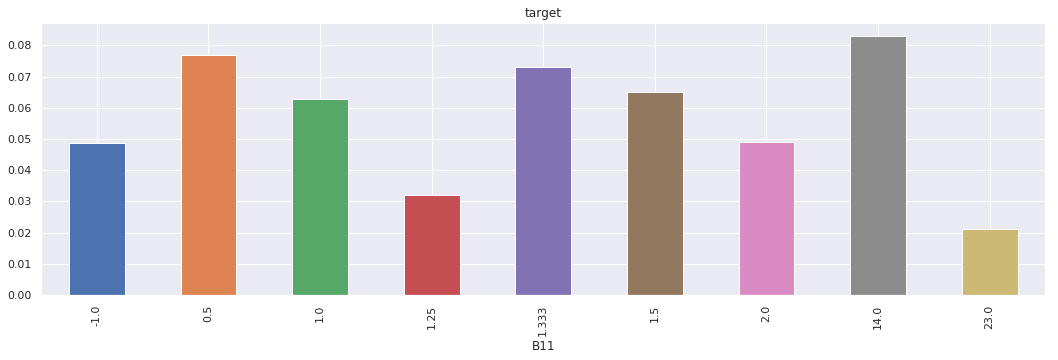

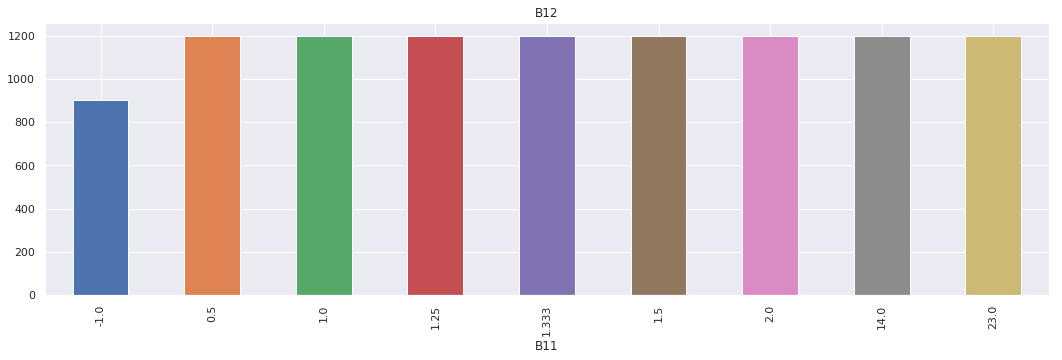

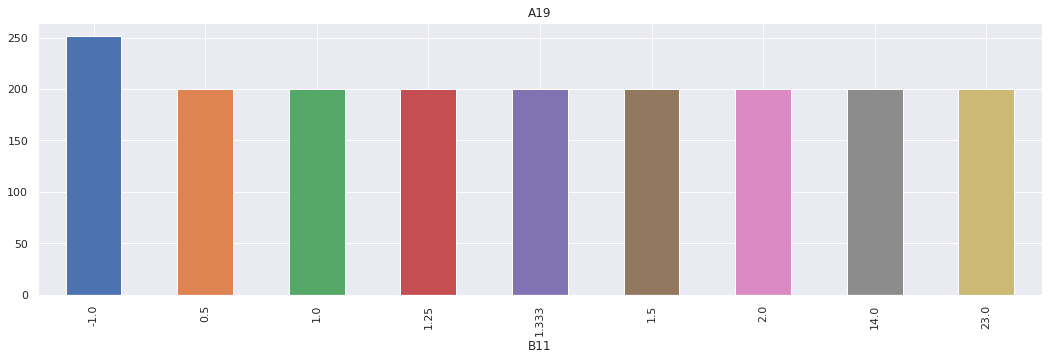

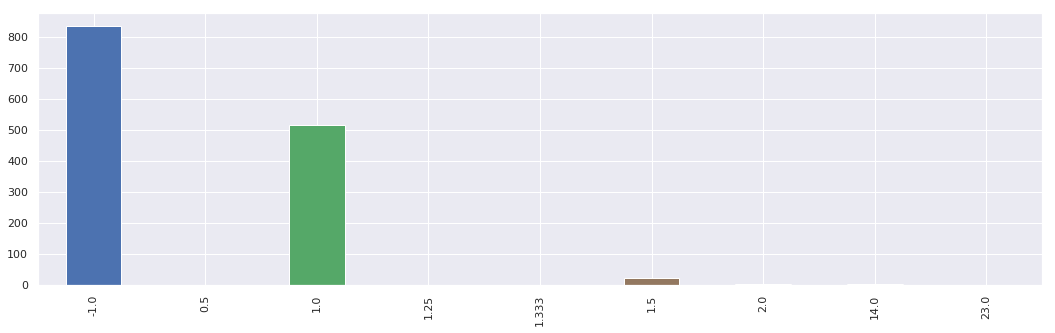

-1.000     836
 0.500       1
 1.000     516
 1.250       1
 1.333       1
 1.500      23
 2.000       2
 14.000      2
 23.000      1
Name: B11, dtype: int64

In [44]:
plt_A_B(train_data, 'B11', 'target', 0.87)
plt_A_B(train_data, 'B11', 'B12', 0)
plt_A_B(train_data, 'B11', 'A19', 0)
plt_cnt(train_data, 'B11')

## 构造特征

### 删除弱相关特征

In [215]:
def get_idx_by_th(pd_data, threshold):
    corrmat = pd_data.corr()
    cols = corrmat.nlargest(pd_data.shape[1], target_name)[target_name].index
    cm = abs(np.corrcoef(pd_data[cols].values.T))
    chosed_idx = cols[cm[0][0:]>threshold]
    return chosed_idx

chosed_idx = get_idx_by_th(full[:train.shape[0]], 0.15)

### 增加特征

In [275]:
def make_new_features(full):
    
    mix_feature = full.copy()
    
    # 将 B14 分段
    mix_feature['B14_385_430'] = mix_feature['B14']
    mix_feature.loc[mix_feature['B14'].apply(lambda x: x>370 and x<430), ['B14_385_430']] = 0
    mix_feature.loc[mix_feature['B14']<385, ['B14_385_430']] = 1
    mix_feature.loc[mix_feature['B14']>430, ['B14_385_430']] = 2
#     mix_feature.drop(['B14'], axis=1, inplace=True)


    # 增加 B10_null，删除 B10，B9
    mix_feature['B10_null'] = 0
    mix_feature.loc[mix_feature['B10']==-1, ['B10_null']] = 1
    # mix_feature.drop(['B10'], axis=1, inplace=True)
    # mix_feature.drop(['B9'], axis=1, inplace=True)
    
    
    # 增加 B11_null，删除 B11
    mix_feature['B11_null'] = 0
    mix_feature.loc[mix_feature['B11']==-1, ['B11_null']] = 1
    # mix_feature.drop(['B11'], axis=1, inplace=True)
    
    
    # 删除不必要的温度
    # mix_feature.drop(['A12'], axis=1, inplace=True)
    # mix_feature.drop(['A15'], axis=1, inplace=True)
    # mix_feature.drop(['A17'], axis=1, inplace=True)
    
    
    # 删除与 A10 相关性大的 A25, B6, B12
    # mix_feature.drop(['A25'], axis=1, inplace=True)
    # mix_feature.drop(['B6'], axis=1, inplace=True)
    # mix_feature.drop(['B12'], axis=1, inplace=True)
    
    
    # A19 分类
    mix_feature['A19_cat'] = 2
    mix_feature.loc[mix_feature['A19']<=150, ['A19_cat']] = 0
    mix_feature.loc[mix_feature['A19']>=250, ['A19_cat']] = 1
    # mix_feature.drop(['A19'], axis=1, inplace=True)
    
    
    # 增加 A3_null，删除 A3, A4
    mix_feature['A3_null'] = 0
    mix_feature.loc[mix_feature['A3']==-1, ['A3_null']] = 1
    # mix_feature.drop(['A4'], axis=1, inplace=True)
    # mix_feature.drop(['A3'], axis=1, inplace=True)
    
    return mix_feature

In [277]:
# mix_feature = make_new_features(full[chosed_idx])
mix_feature = make_new_features(full)
print("Change feature number form {} to {}".format(full.shape[1], mix_feature.shape[1]))

Change feature number form 49 to 51


### 剩余特征的相关系数矩阵

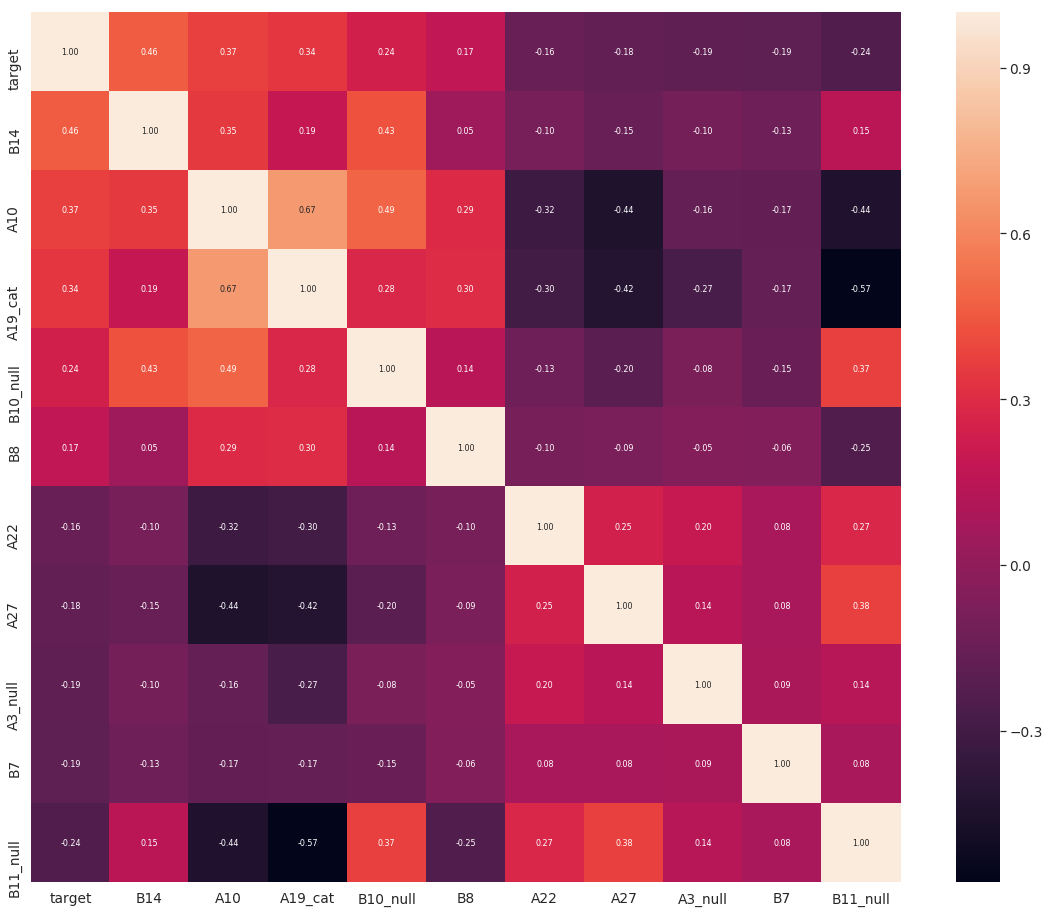

In [225]:
# heatmap_font(mix_feature[:n_train])

In [256]:
mix_feature['id'] = full['id']
# show_data(mix_feature)

## 观察剩余类别多的值

### B8
直接当连续值处理

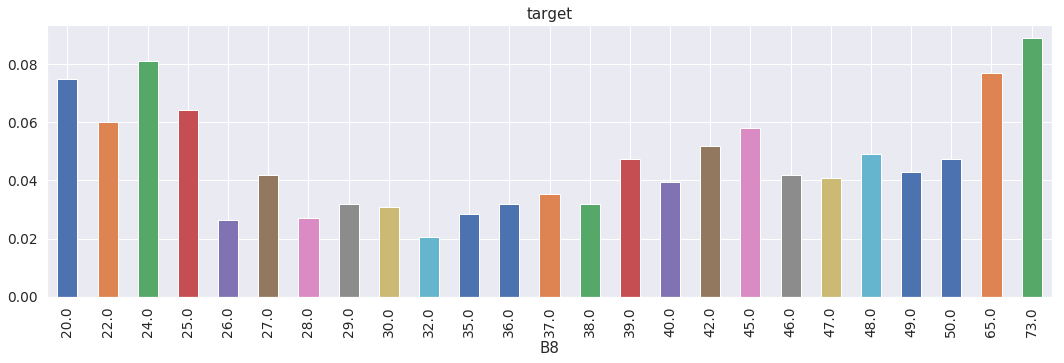

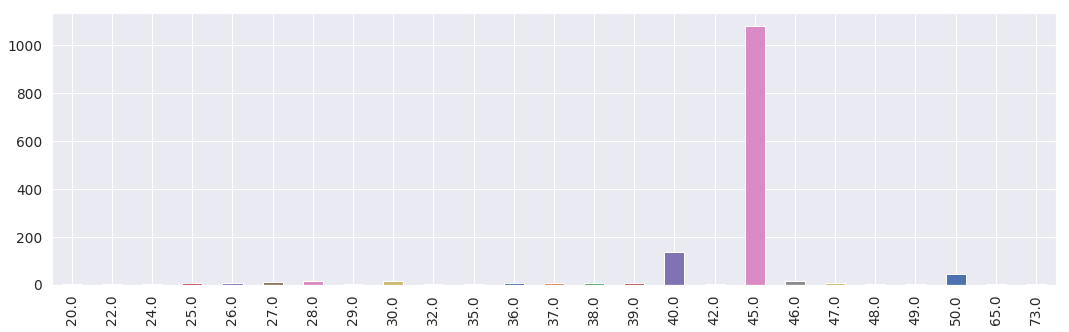

In [57]:
plt_A_B(train_data, 'B8', 'target', 0.87)
plt_cnt(train_data, 'B8');

### A27
当连续值处理

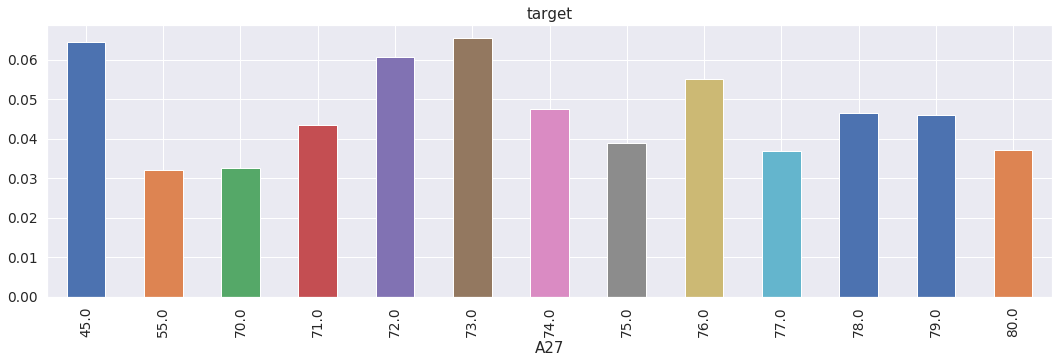

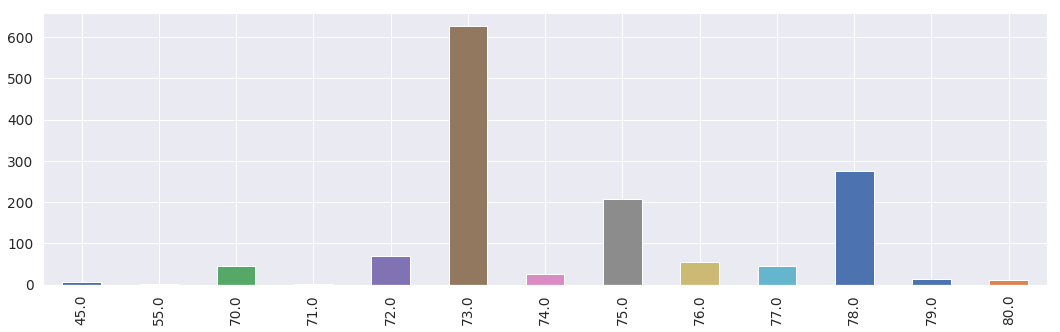

In [58]:
plt_A_B(train_data, 'A27', 'target', 0.87)
plt_cnt(train_data, 'A27');

### B7
当连续值处理

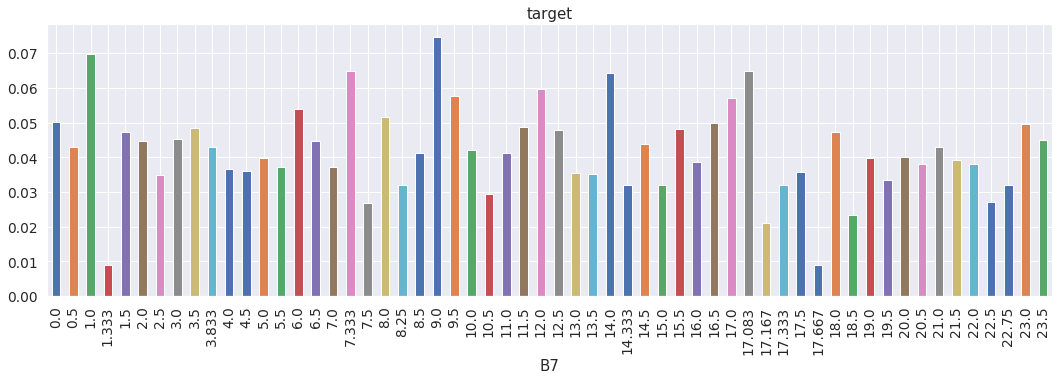

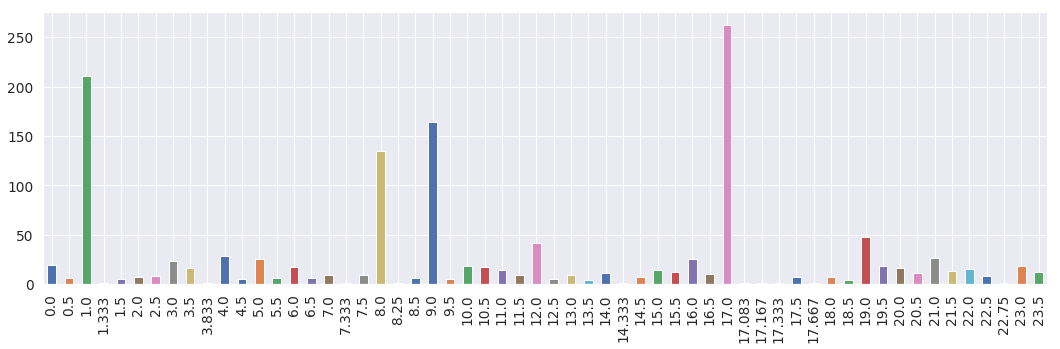

In [59]:
plt_A_B(train_data, 'B7', 'target', 0.87)
plt_cnt(train_data, 'B7');

## RF 单特征选择

In [373]:
def feature_selected(X_train, y_train, name):
    #n_estimators为森林中树木数量，max_depth树的最大深度
    rf = RandomForestRegressor() #n_estimators=20, max_depth=4
    scores = []

    for i in range(X_train.shape[1]):
        #每次选择一个特征，进行交叉验证，训练集和测试集为7:3的比例进行分配，
        #ShuffleSplit()函数用于随机抽样（数据集总数，迭代次数，test所占比例）, cv=ShuffleSplit(len(X_train), 3, .3)
        score = -cross_val_score(rf, X_train[:, i:i+1], y_train, scoring="neg_mean_squared_error", cv=5)
        scores.append((round(np.mean(score), 7), name[i]))
        print("The score of feature {} is {}, {}/{}".format(scores[i][1], scores[i][0], i, X_train.shape[1]), end="\r")

    #打印出各个特征所对应的得分
    print(sorted(scores, reverse=False))
    return sorted(scores, reverse=False)

In [376]:
scores = feature_selected(train_data.drop([target_name, 'B14'], axis=1).values,
                     train['B14'],
                     train_data.drop([target_name], axis=1).columns)

[(380.854685, 'B9'), (419.502803, 'B8'), (474.1753892, 'B1'), (502.3109299, 'B12'), (517.8799015, 'B10'), (528.3874675, 'A4'), (531.7388284, 'A3'), (543.2948471, 'A1'), (555.6780153, 'A10'), (566.0756601, 'A25'), (566.173764, 'A6'), (577.474408, 'A12'), (582.7340931, 'B5'), (587.3219967, 'A16'), (589.3965801, 'A11'), (591.2552772, 'A9'), (594.3905087, 'A14'), (596.2346621, 'B4'), (597.8010037, 'A27'), (600.0317017, 'A16-A9'), (603.8229219, 'A26'), (605.4302728, 'A24'), (606.5443887, 'A21'), (607.6325825, 'A17'), (611.6891152, 'A20'), (613.2964954, 'A19'), (616.1307802, 'A5'), (619.788907, 'A15'), (622.5034539, 'B11'), (623.65764, 'B6'), (624.4136676, 'A26-A24'), (628.4287434, 'A22'), (629.6170206, 'B3'), (631.7781619, 'B13'), (636.4301824, 'A18'), (636.6657721, 'B2'), (636.8726106, 'A13'), (636.8991584, 'A23'), (637.4966739, 'B14'), (638.5771462, 'A14-A9'), (638.6889053, 'A28'), (639.5477936, 'id'), (640.0873642, 'A11-A9'), (686.7099209, 'B7')]


In [278]:
# [name for score, name in scores if score < 0.00075]

### 选择特征

In [123]:
selected_idx = ['B14', 'id', 'B6', 'B12', 'B1', 'A6', 'B7', 'A27', 'B5', 'A5', 'A14', 'A10']
# selected_idx = ['B14', 'B12', 'B1', 'A20', 'A6', 'id', 'A10', 'A25', 'B6', 'A27', 'A26-A24', 'A19']
rf_selected_feature = full[selected_idx].copy()

In [124]:
# rf_selected_feature.loc[rf_selected_feature[rf_selected_feature['B14']==785].index, ['B14']] = 385


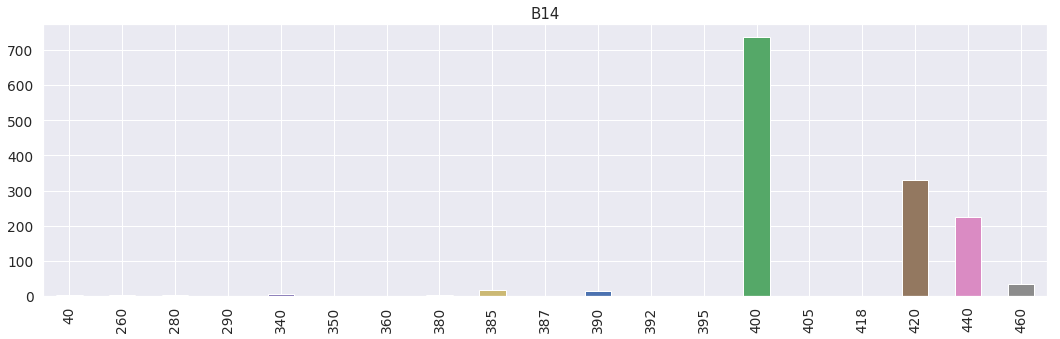

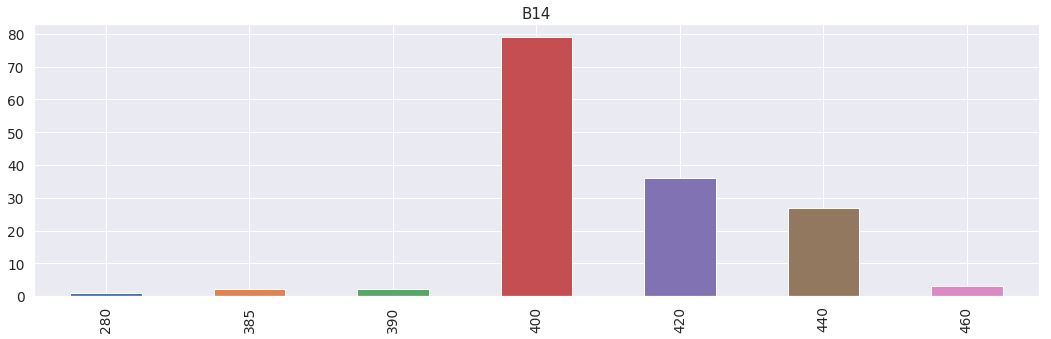

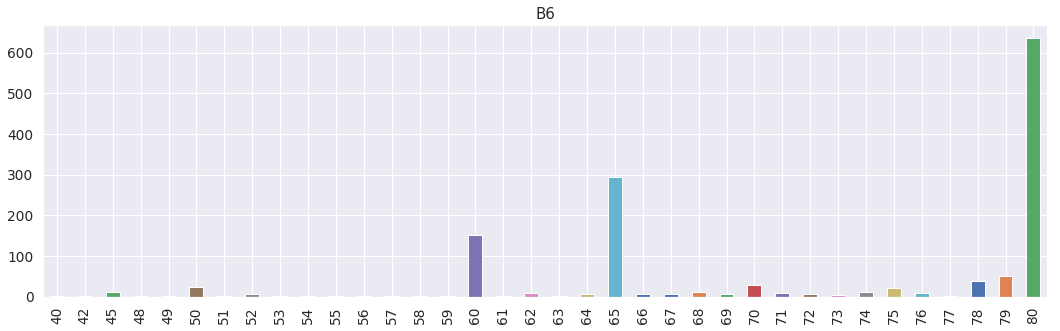

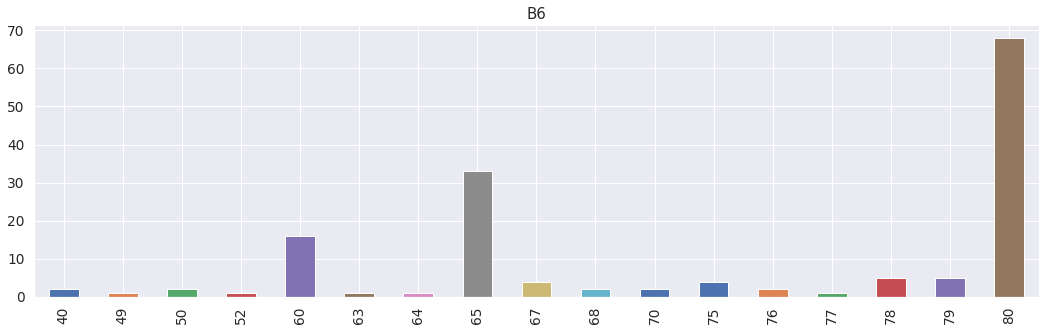

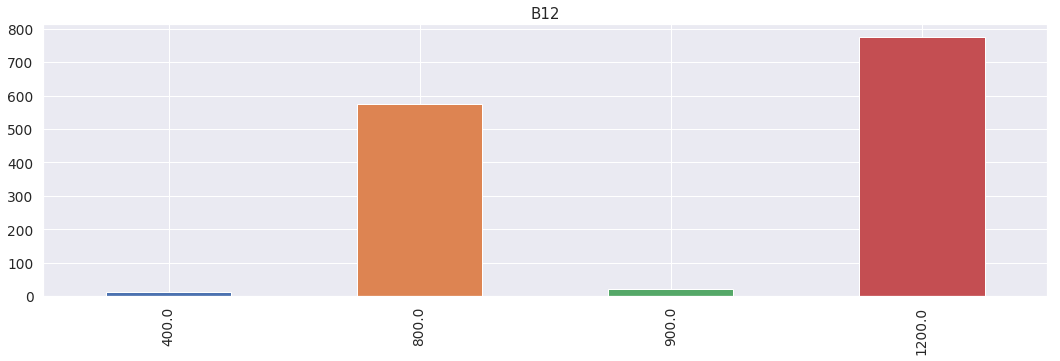

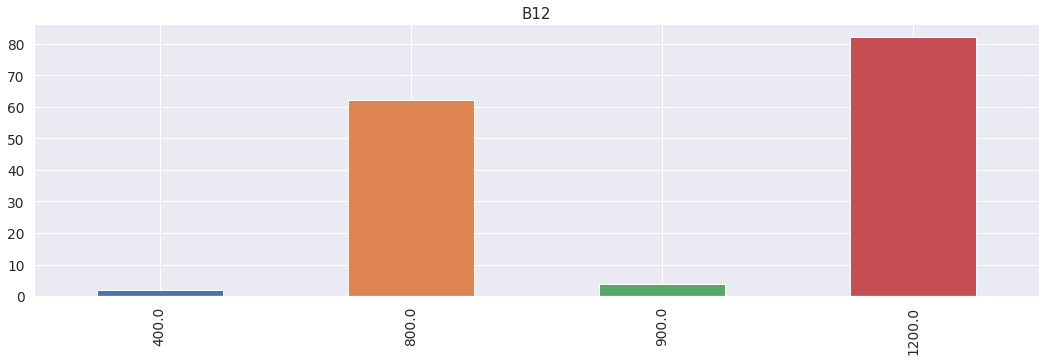

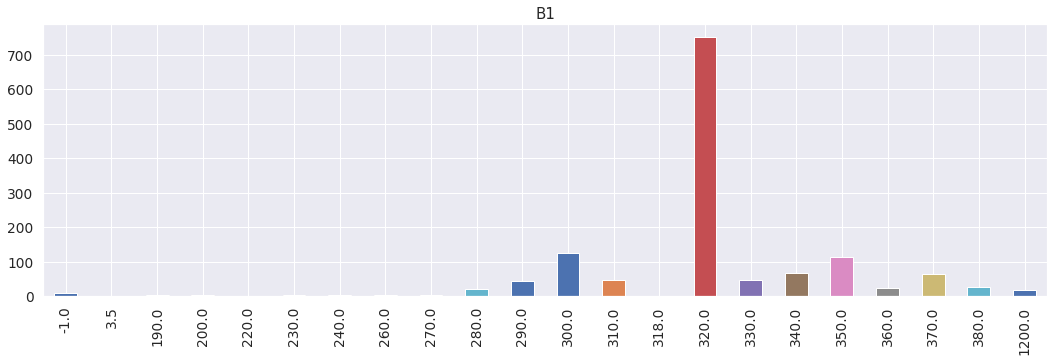

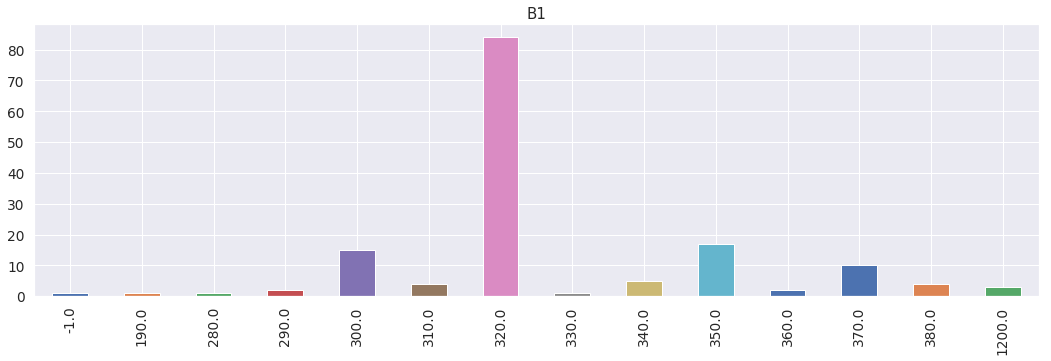

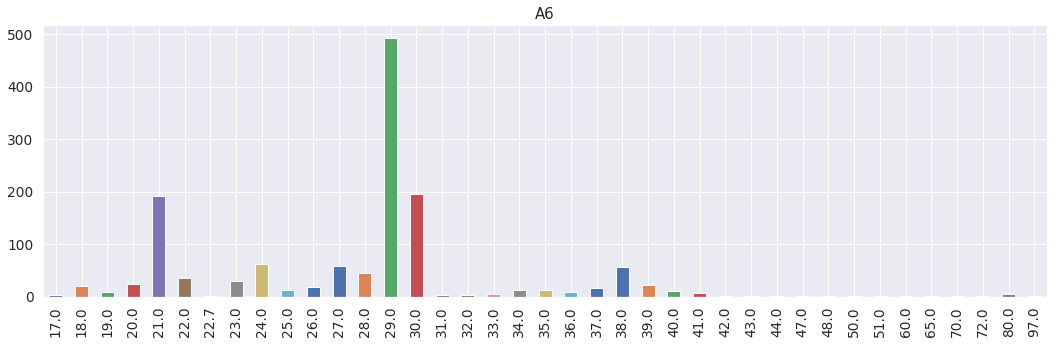

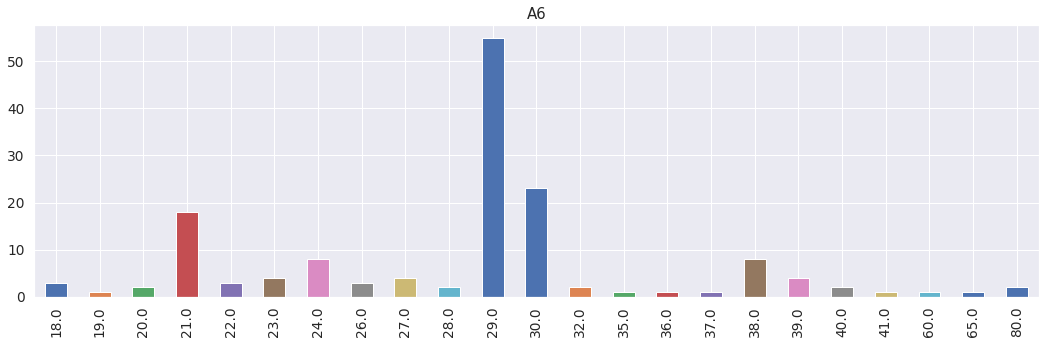

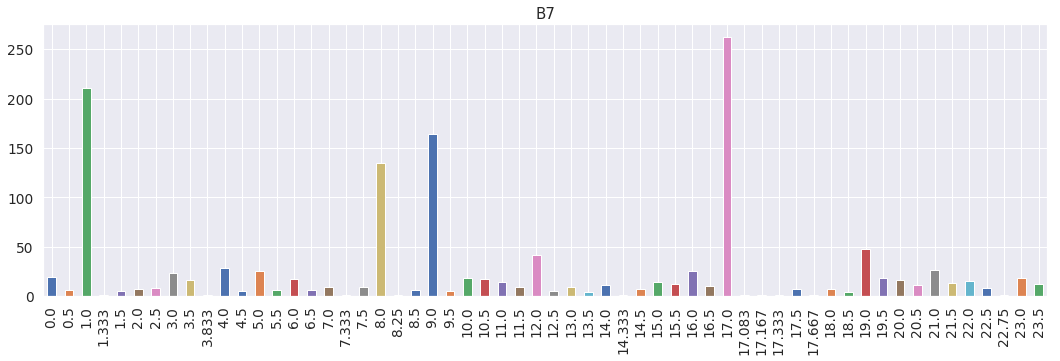

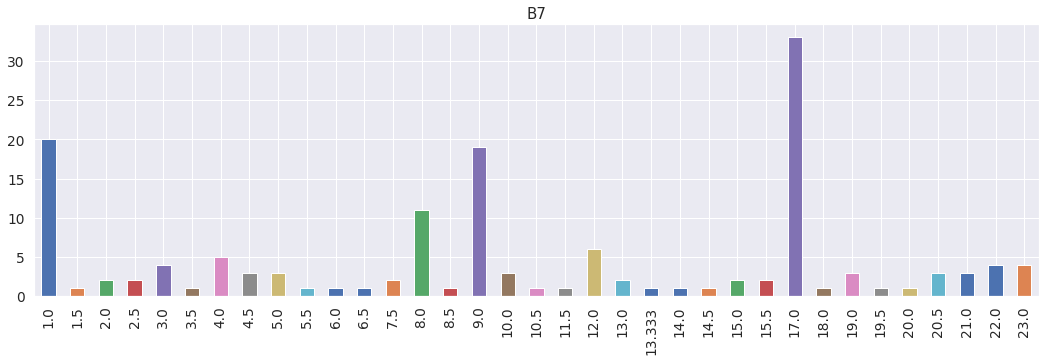

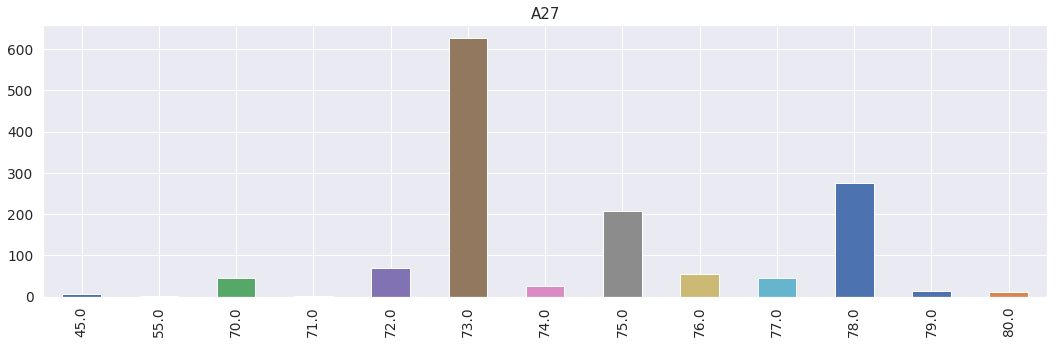

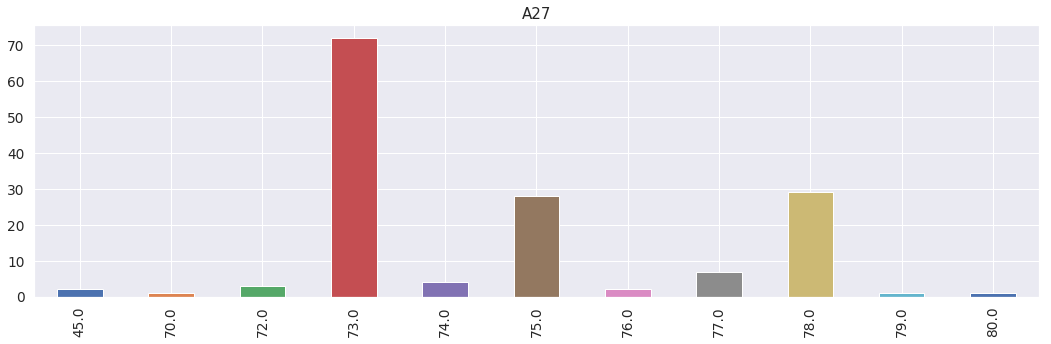

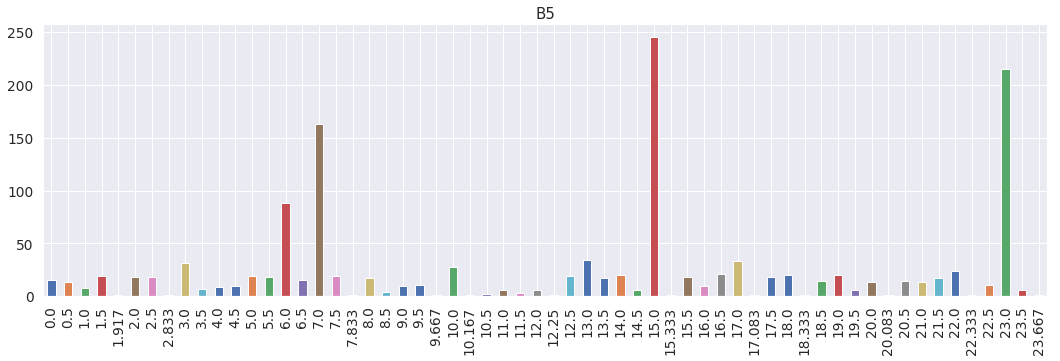

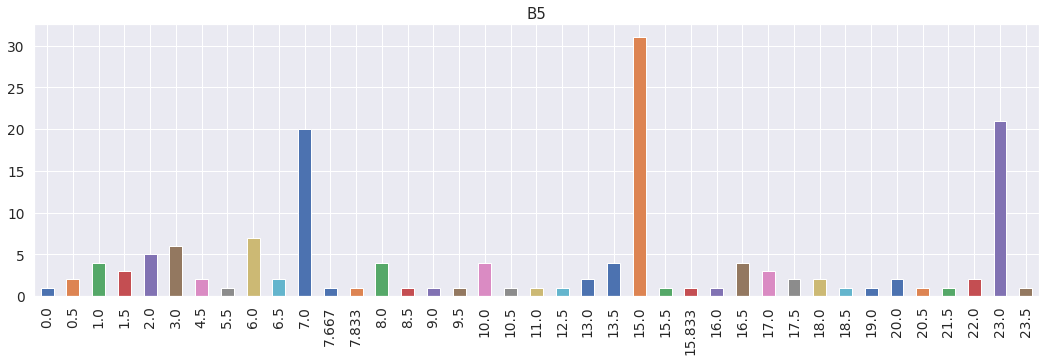

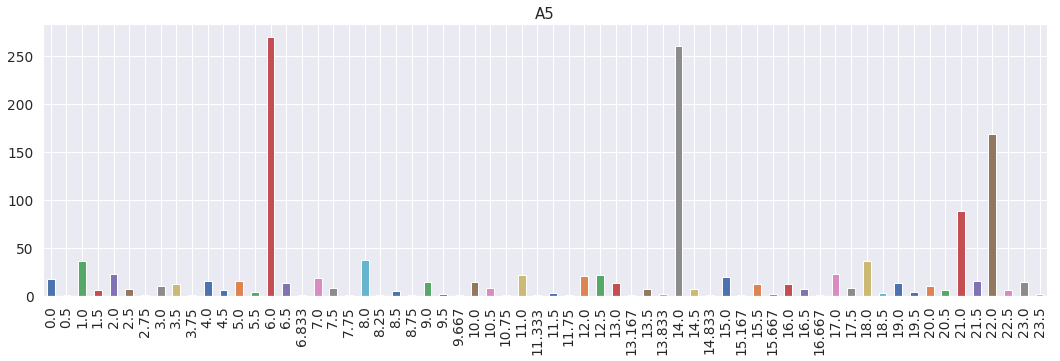

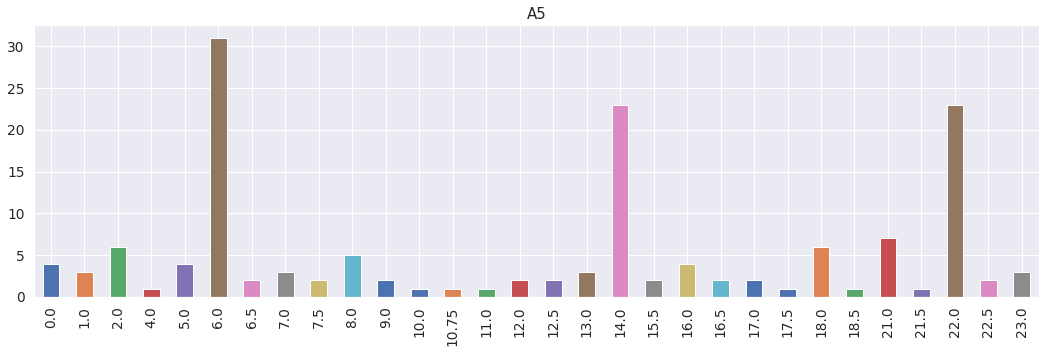

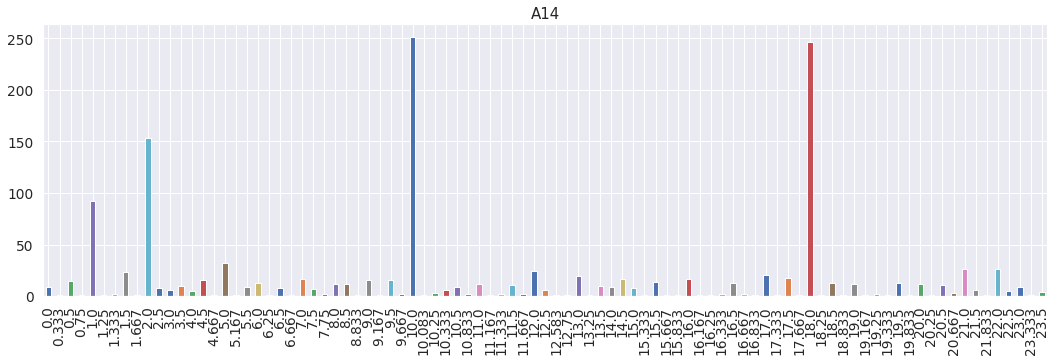

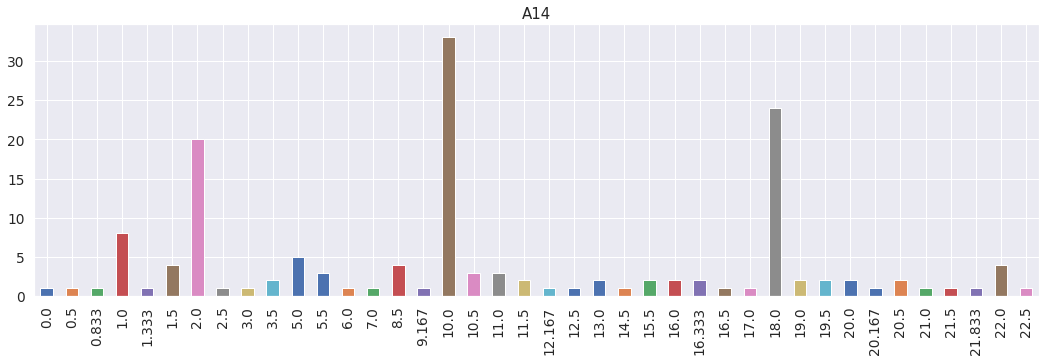

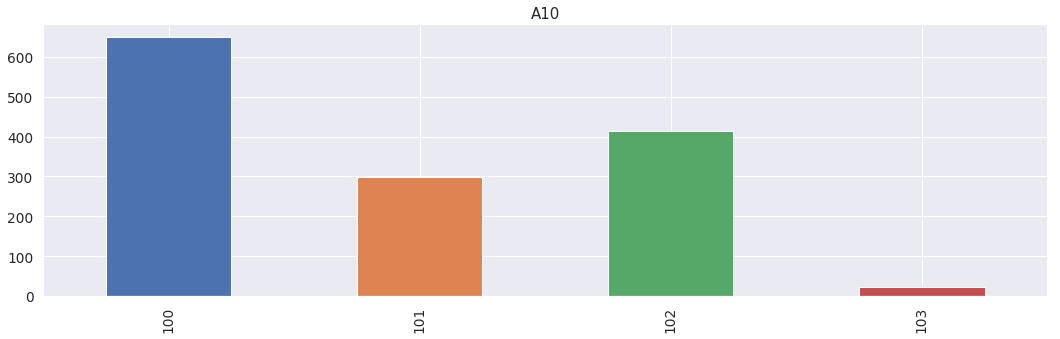

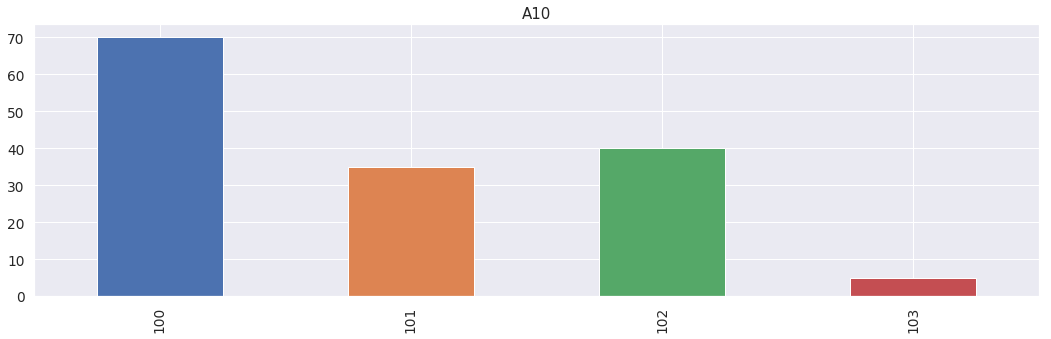

In [125]:
# rf_selected_feature[:n_train]['B14'].value_counts(dropna=False).sort_index(ascending=True)
for col in [idx for idx in selected_idx if idx != 'id']:
    plt_cnt(rf_selected_feature[:n_train], col)
    plt_cnt(rf_selected_feature[n_train:], col)


## 后向特征选择

In [245]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=2018)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
#         print("fold n°{}".format(fold_+1))
        trn_data = xgb.DMatrix(X[trn_idx], y[trn_idx])
        val_data = xgb.DMatrix(X[val_idx], y[val_idx])

        num_round = 20000
        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, verbose_eval=False, early_stopping_rounds=200, params=params)
        oof_preds[val_idx] = clf.predict(xgb.DMatrix(X[val_idx]), ntree_limit=clf.best_ntree_limit)

    score = mean_squared_error(oof_preds, y)
    print('-'*100, end='\n\n')

    
    return  score

In [246]:
def featureSelect(train, init_cols, target):
    params = {'eta': 0.1, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
              'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
    
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        if diff > 0.0000001:
            print("当前选择特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！！！"
                  .format(f,score,best_score))
            best_score = score
        else:
            print("当前选择特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 保留"
                  .format(f,score,best_score))
            best_cols.append(f)
    
    print('-'*100)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols
    

In [260]:
init_cols = [f for f in mix_feature.columns if f not in [target_name]]
best_features = featureSelect(mix_feature[:n_train][init_cols],
                              init_cols,
                              train_data[target_name])

----------------------------------------------------------------------------------------------------

初始CV score: 0.00013828
----------------------------------------------------------------------------------------------------

当前选择特征: A1, CV score: 0.00013664, 最佳cv score: 0.00013828, 有效果,删除！！！！
----------------------------------------------------------------------------------------------------

当前选择特征: A10, CV score: 0.00013684, 最佳cv score: 0.00013664, 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A11, CV score: 0.00013971, 最佳cv score: 0.00013664, 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A12, CV score: 0.00014091, 最佳cv score: 0.00013664, 保留
----------------------------------------------------------------------------------------------------

当前选择特征: A13, CV score: 0.00013876, 最佳cv score: 0.00013664, 保留
------------------------------------------------

In [264]:
best_features.append('target')
back_selscted_feature = mix_feature[best_features].copy()

## target 分箱

In [360]:
def target_merge(train, test, target, categorical_columns):
    
    
    train['intTarget'] = pd.cut(train['target'], 5, labels=False)
    train = pd.get_dummies(train, columns=['intTarget'])
    li = ['intTarget_0','intTarget_1','intTarget_2','intTarget_3','intTarget_4']
    mean_columns = []
    for f1 in categorical_columns:
        cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
        if cate_rate < 0.90:
            for f2 in li:
                col_name = 'B14_to_'+f1+"_"+f2+'_mean'
                mean_columns.append(col_name)
                order_label = train.groupby([f1])[f2].mean()
#                 print("f1 = {}, f2 = {}, order_label = \n{}".format(f1, f2, order_label))
                train[col_name] = train[f1].map(order_label)
                test[col_name] = test[f1].map(order_label)
        
                miss_rate = test[col_name].isnull().sum() * 100 / test[col_name].shape[0]
                if miss_rate > 0:
                    print("miss_rate of {} to {} is {}".format(f1, f2, miss_rate))
                    print("f1 = {}, f2 = {}, order_label = \n{}".format(f1, f2, order_label))
                    train = train.drop([col_name], axis=1)
                    test = test.drop([col_name], axis=1)
                    mean_columns.remove(col_name)

    train.drop(li+['target'], axis=1, inplace=True)
    print(train.shape)
    print(test.shape)
    data = pd.concat([train, test]) 
    print(data.shape)
    return data, mean_columns

In [361]:
categorical_columns = [f for f in back_selscted_feature.columns if f not in ['id', 'target']]
numerical_columns = [f for f in back_selscted_feature.columns if f not in categorical_columns+['target']]

for f in categorical_columns:
    back_selscted_feature[f] = back_selscted_feature[f].map(
        dict(zip(back_selscted_feature[f].unique(), range(0, back_selscted_feature[f].nunique()))))
        
dummies_feature, mean_columns = target_merge(back_selscted_feature[:n_train], 
                                     back_selscted_feature[n_train:].drop(['target'], axis=1), 
                                     back_selscted_feature[:n_train]['target'], 
                                     categorical_columns)

miss_rate of A11 to intTarget_0 is 2.0
f1 = A11, f2 = intTarget_0, order_label = 
A11
0     0.411765
1     0.044898
2     0.129032
3     0.111111
4     0.111111
5     0.125000
6     0.039841
7     0.307692
8     0.235294
9     0.184783
10    0.333333
11    0.333333
12    0.166667
13    0.111111
14    0.272727
15    0.181818
16    0.125000
17    0.357143
18    0.300000
19    0.272727
20    1.000000
21    0.250000
22    0.333333
23    0.750000
24    0.090909
25    0.000000
26    0.166667
27    0.285714
28    0.230769
29    0.333333
        ...   
61    1.000000
62    0.000000
63    0.000000
64    0.000000
65    0.500000
66    0.500000
67    0.272727
68    0.000000
69    1.000000
70    0.500000
71    0.000000
72    1.000000
73    1.000000
74    0.000000
75    0.000000
76    0.500000
77    1.000000
78    0.000000
79    0.000000
80    1.000000
81    0.000000
82    0.000000
83    1.000000
84    1.000000
85    0.000000
86    0.000000
87    0.000000
88    0.000000
89    1.000000
90    0.000000

miss_rate of A9 to intTarget_0 is 2.6666666666666665
f1 = A9, f2 = intTarget_0, order_label = 
A9
0     0.411765
1     0.048780
2     0.125000
3     0.105960
4     0.111111
5     0.125000
6     0.043651
7     0.307692
8     0.187500
9     0.184783
10    0.285714
11    0.363636
12    0.200000
13    0.111111
14    0.200000
15    0.181818
16    0.125000
17    0.357143
18    0.333333
19    0.300000
20    1.000000
21    0.238095
22    0.333333
23    0.600000
24    0.090909
25    0.000000
26    0.176471
27    0.285714
28    0.230769
29    0.333333
        ...   
62    0.000000
63    0.000000
64    0.500000
65    0.500000
66    0.272727
67    0.000000
68    1.000000
69    0.500000
70    0.000000
71    1.000000
72    1.000000
73    0.000000
74    0.000000
75    0.500000
76    1.000000
77    0.000000
78    0.000000
79    1.000000
80    1.000000
81    0.000000
82    0.000000
83    0.000000
84    1.000000
85    1.000000
86    0.000000
87    0.000000
88    0.000000
89    0.000000
90    1.000000
91

miss_rate of B9 to intTarget_1 is 0.6666666666666666
f1 = B9, f2 = intTarget_1, order_label = 
B9
0     0.325373
1     0.066667
2     0.026882
3     0.296296
4     0.350000
5     0.588235
6     0.086957
7     0.400000
8     0.181818
9     0.478261
10    0.000000
11    0.000000
12    0.000000
13    0.000000
Name: intTarget_1, dtype: float64
miss_rate of B9 to intTarget_2 is 0.6666666666666666
f1 = B9, f2 = intTarget_2, order_label = 
B9
0     0.343284
1     0.666667
2     0.725806
3     0.259259
4     0.300000
5     0.117647
6     0.739130
7     0.200000
8     0.727273
9     0.478261
10    0.000000
11    1.000000
12    0.000000
13    0.000000
Name: intTarget_2, dtype: float64
miss_rate of B9 to intTarget_3 is 0.6666666666666666
f1 = B9, f2 = intTarget_3, order_label = 
B9
0     0.090547
1     0.266667
2     0.150538
3     0.018519
4     0.050000
5     0.000000
6     0.173913
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
Name: in

In [315]:
def one_hot(data, train, test, mean_columns, numerical_columns, categorical_columns):
    X_train = train[mean_columns+numerical_columns].values
    X_test = test[mean_columns+numerical_columns].values
    # one hot
    enc = OneHotEncoder()
    for f in categorical_columns:
        enc.fit(data[f].values.reshape(-1, 1))
        X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
        X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
    print(X_train.shape)
    print(X_test.shape)
    
    data = pd.concat([X_train, X_test]) 
    print(data.shape)
    return data

In [362]:
# one_hot_data = one_hot(dummies_feature,
#                        dummies_feature[:n_train],
#                       dummies_feature[n_train:],
#                       mean_columns,
#                       numerical_columns,
#                       categorical_columns)

<span id="4"></span>


# 特征处理

[回到目录](#content)

## 构建 pipeline

+ __将温度 fit_transform__

In [65]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        num_col = ['B14', 'B8', 'A27', 'B7']
        obj_col = [col for col in X.columns if col not in num_col]
        X[num_col] = X[num_col].astype(float)
        X[obj_col] = X[obj_col].astype(object)
        return X

+ __修正偏度__

In [66]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        print("skewness_features = {}".format(skewness_features))
        X[skewness_features] = np.log1p(X[skewness_features])
        
#         enc = OneHotEncoder()
#         for f in categorical_columns:
#             enc.fit(X.values.reshape(-1, 1))
#             X = sparse.hstack((X, enc.transform(X.values.reshape(-1, 1))), 'csr')
        
#         X = pd.get_dummies(X)
        return X

In [67]:
# build pipeline
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

## scale + PCA

In [127]:
def split_data(data, target, pipe=None, scaler_en=False, pca_en=False, pca_n=1200):
    n_train = target.shape[0]

    if pipe:
        data = pipe.fit_transform(data)
        print("After pipeline, feature number is {}".format(data.shape[1]))
        
    cate_columns = [f for f in data.columns if f not in [target_name]] #, 'id'
    X_train = data[:n_train][cate_columns].values.astype(np.float64)
    y_train = target
    X_test = data[n_train:][cate_columns].values.astype(np.float64)
        
    if scaler_en:
        scaler = RobustScaler()
        X_train = scaler.fit(X_train).transform(X_train)
        X_test = scaler.transform(X_test)
        
    if pca_en:
        pca = PCA(n_components=pca_n)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
    return X_train, y_train, X_test

## 获得训练集与测试集

In [363]:
X_train, y_train, X_test = split_data(dummies_feature,
                                      train[target_name].values,
                                      pipe = None,
                                      scaler_en = False,
                                      pca_en = False, 
                                      pca_n = 10)

X_train.shape, y_train.shape, X_test.shape, X_train.dtype, y_train.dtype, X_test.dtype

((1383, 119),
 (1383,),
 (150, 119),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

<span id="5"></span>


# 训练模型

[回到目录](#content)

## 多模型测试

In [129]:
def mse_cv(model,X,y):
    mse = -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)
    return mse

In [130]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]

In [324]:
def model_test(X, y):
    names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
    for name, model in zip(names, models):
        score = mse_cv(model, X, y)
        print("{}: {:.6f}, {:.4f}".format(name, score.mean(), score.std()))
        
# model_test(X_scaled, y_train)
model_test(X_train, y_train)

LR: 0.000639, 0.0006
Ridge: 0.000230, 0.0000
Lasso: 0.000691, 0.0001
RF: 0.000150, 0.0000
GBR: 0.000135, 0.0000
SVR: 0.000929, 0.0001
LinSVR: 0.018075, 0.0247
Ela: 0.000279, 0.0000
SGD: 207114130457964693625872842752.000000, 113385763901409195019634475008.0000
Bay: 0.000229, 0.0000
Ker: 0.000473, 0.0001
Extra: 0.000145, 0.0000
Xgb: 0.000132, 0.0000


## 画结果对比图

In [143]:
def result_plot(pred, truth):
    plt.figure(figsize=(12,5))
    sns.distplot(pred, bins=50, kde=False, color="red")
    plt.title("Predict")
    # plt.xlabel('yield', fontsize=12)

    plt.show()
    plt.figure(figsize=(12,5))
    sns.distplot(truth, bins=50, kde=False, color="red")
    plt.title("Ground truth")
    plt.show()
    
# Y_pred = model.predict(X_train[1000:])
# result_plot(Y_pred, y_train)

## lbg

In [364]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000222332	valid_1's l2: 0.000231332
[400]	training's l2: 0.000147295	valid_1's l2: 0.000171461
[600]	training's l2: 0.00011454	valid_1's l2: 0.000152369
[800]	training's l2: 9.9565e-05	valid_1's l2: 0.000146387
[1000]	training's l2: 9.01939e-05	valid_1's l2: 0.000144127
[1200]	training's l2: 8.35043e-05	valid_1's l2: 0.000143078
[1400]	training's l2: 7.87333e-05	valid_1's l2: 0.000142303
Early stopping, best iteration is:
[1471]	training's l2: 7.72917e-05	valid_1's l2: 0.000142279
fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000212813	valid_1's l2: 0.000262928
[400]	training's l2: 0.000139744	valid_1's l2: 0.00021194
[600]	training's l2: 0.000110548	valid_1's l2: 0.000192529
[800]	training's l2: 9.6151e-05	valid_1's l2: 0.000183849
[1000]	training's l2: 8.72409e-05	valid_1's l2: 0.000180258
[1200]	training's l2: 8.10457e-05	valid_1's l2: 0.000

## gbr

## xgb

In [365]:
##### xgb
def xgb_predict(X_train, y_train, X_test):
    xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
              'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

    folds = KFold(n_splits=5, shuffle=True, random_state=2018)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        print("fold n°{}".format(fold_+1))
        print("len trn_idx  {}".format(len(trn_idx)))
        trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
        val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
        predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

    print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))
    return oof_xgb, predictions_xgb

In [366]:
oof_xgb, predictions_xgb = xgb_predict(X_train, y_train, X_test)

fold n°1
len trn_idx  1106
[0]	train-rmse:0.422865	valid_data-rmse:0.423734
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.257074	valid_data-rmse:0.257616
[200]	train-rmse:0.156793	valid_data-rmse:0.157006
[300]	train-rmse:0.096245	valid_data-rmse:0.096085
[400]	train-rmse:0.059783	valid_data-rmse:0.05962
[500]	train-rmse:0.037858	valid_data-rmse:0.03797
[600]	train-rmse:0.02465	valid_data-rmse:0.025346
[700]	train-rmse:0.016615	valid_data-rmse:0.018275
[800]	train-rmse:0.01171	valid_data-rmse:0.014539
[900]	train-rmse:0.008802	valid_data-rmse:0.012719
[1000]	train-rmse:0.007015	valid_data-rmse:0.011932
[1100]	train-rmse:0.005892	valid_data-rmse:0.011651
[1200]	train-rmse:0.005178	valid_data-rmse:0.011577
[1300]	train-rmse:0.004644	valid_data-rmse:0.011589
[1400]	train-rmse:0.004224	valid_data-rmse:0.011638
Stopping. Best iteration:
[1253]	train-rmse:0.004875	

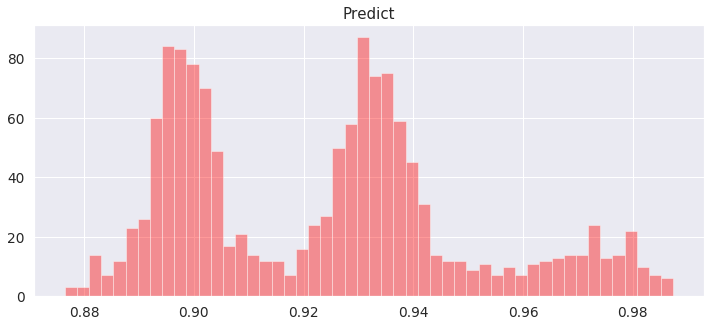

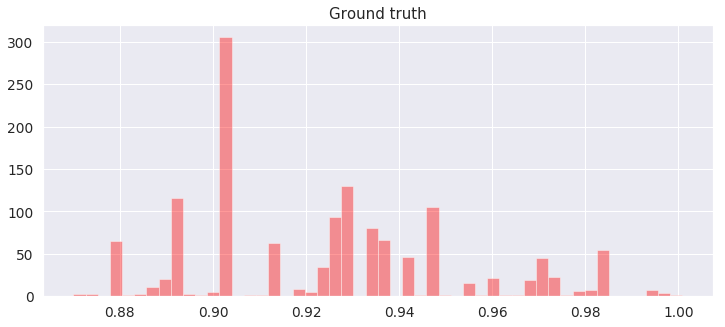

In [328]:
result_plot(oof_xgb, y_train)
train[target_name].value_counts();

## AutoKeras

## AutoML

In [230]:
def auto_train(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=2018)

    tpot = TPOTRegressor(generations=5, population_size=5, verbosity=2, random_state=2018, warm_start=True)
    tpot.fit(X_train, y_train)
    print(tpot.score(X_test, y_test))
    tpot.export('jinnan.py')

In [231]:
# tpot = auto_train(X_train, y_train)

Generation 1 - Current best internal CV score: -0.00017207749825212448
Generation 2 - Current best internal CV score: -0.00017207749825212448
Generation 3 - Current best internal CV score: -0.00017207749825212448
Generation 4 - Current best internal CV score: -0.00017207749825212448
Generation 5 - Current best internal CV score: -0.00017207749825212448

Best pipeline: DecisionTreeRegressor(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.35000000000000003), max_depth=6, min_samples_leaf=1, min_samples_split=10)
-0.0001631016327299148


## 自动生成的程序

In [357]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.feature_selection import VarianceThreshold
from tpot.builtins import StackingEstimator


def mode_pipeline(scre = 173):
    if scre == 173:
        # Average CV score on the training set was:-0.00017397577033911776
        exported_pipeline = make_pipeline(
            MinMaxScaler(),
            GradientBoostingRegressor(alpha=0.85, learning_rate=0.1, loss="huber", max_depth=6, max_features=0.5, min_samples_leaf=1, min_samples_split=17, n_estimators=100, subsample=0.8, random_state=2018)
        )
    elif scre == 187:
        # Average CV score on the training set was:-0.0001868000824168013
        exported_pipeline = make_pipeline(
            StackingEstimator(estimator=XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=4, n_estimators=100, nthread=1, subsample=0.55, random_state=2018)),
            ExtraTreesRegressor(bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=5, min_samples_split=18, n_estimators=100, random_state=2018)
        )
    else :
        # Average CV score on the training set was:-0.00018611148302895237
        exported_pipeline = make_pipeline(
            StackingEstimator(estimator=XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, nthread=1, subsample=0.35000000000000003, random_state=2018)),
            ExtraTreesRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=3, min_samples_split=10, n_estimators=100, random_state=2018)
        )
        pass
    return exported_pipeline

def auto_predict(X_train, y_train, X_test):

    folds = KFold(n_splits=5, shuffle=True, random_state=2018)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):


        training_features = X_train[trn_idx]
        testing_features = X_train[val_idx]

        training_target = y_train[trn_idx]
        testing_target = y_train[val_idx]
        
        exported_pipeline = mode_pipeline(0)
                
        exported_pipeline.fit(training_features, training_target)

        oof_xgb[val_idx] = exported_pipeline.predict(testing_features)
        predictions_xgb = exported_pipeline.predict(X_test[:14]) / folds.n_splits

        print("folds {}, CV score: {:<8.8f}".format(fold_, mean_squared_error(oof_xgb[val_idx], testing_target)))
    
    print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))
    return predictions_xgb

In [358]:
predictions_auto = auto_predict(X_train, y_train, X_test)

folds 0, CV score: 0.00011183
folds 1, CV score: 0.00013649
folds 2, CV score: 0.00012113
folds 3, CV score: 0.00009439
folds 4, CV score: 0.00011557
CV score: 0.00011590


# 提交结果

In [272]:
predictions = predictions_xgb
sub_df = pd.read_csv('data/jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv('result/change_B14_785_385.csv.csv', header=0, index=0) 

# 对比结果差异

In [83]:
current = pd.read_csv('result/change_B14_785_385.csv.csv', encoding = 'gb18030', header=None)
history  = pd.read_csv('result/all_feature.csv', encoding = 'gb18030', header=None)

current.rename(columns={0:'id', 1:'target'}, inplace = True)
history.rename(columns={0:'id', 1:'target'}, inplace = True)

current['id'] = current['id'].apply(lambda x: int(x.split('_')[1]))
history['id'] = history['id'].apply(lambda x: int(x.split('_')[1]))

current['C_H'] = current['target'] - history['target']

In [59]:
# plt_cnt(current, '0.905')
# plt_cnt(history, '0.905')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


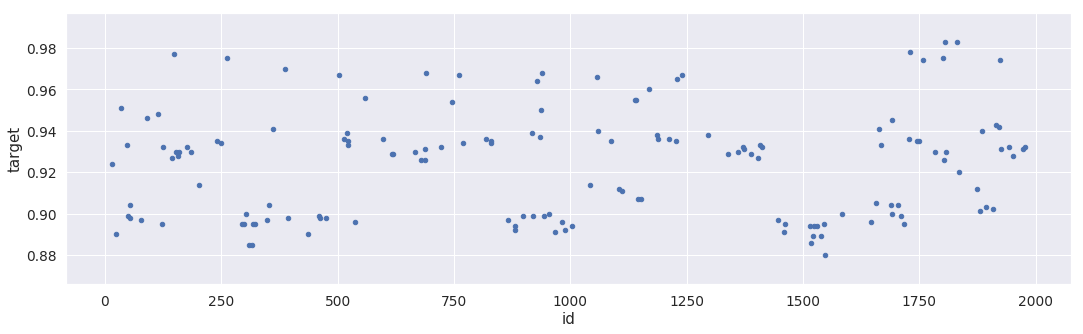

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


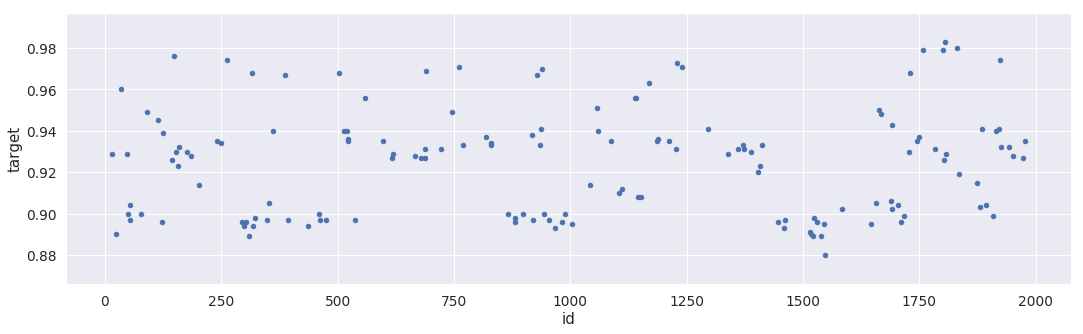

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


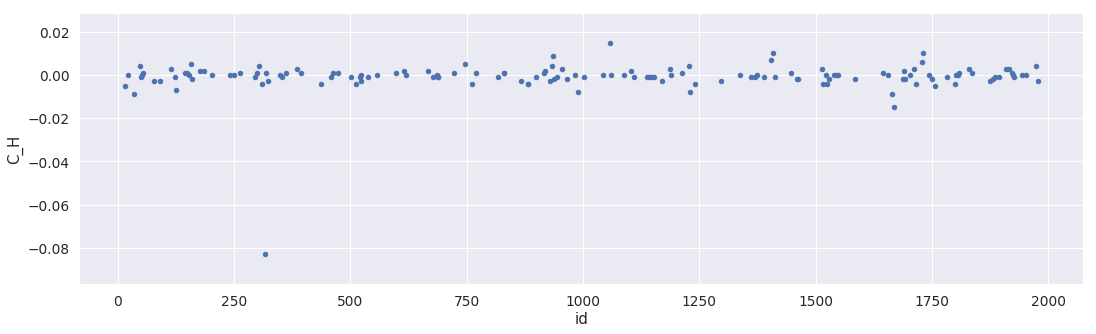

In [84]:
plt_point_A_B(current, 'id', 'target')
plt_point_A_B(history, 'id', 'target')
plt_point_A_B(current, 'id', 'C_H')